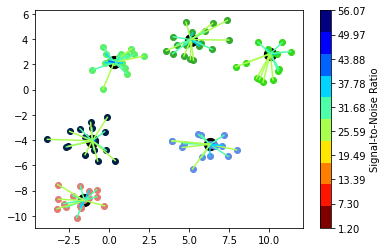

0.7835323810577393
{'Cluster Head': 'client79', 'Members': ['client17', 'client29', 'client31', 'client38', 'client41', 'client42', 'client46', 'client51', 'client54', 'client59', 'client74', 'client81', 'client86', 'client100'], 'SNR': [22.992376651547968, 54.633652822039046, 20.26736287966861, 23.902393140379548, 26.192886809965685, 36.83208174350796, 35.8874615886996, 28.8417722032233, 20.68362534530104, 26.558161455355478, 22.497496015674134, 28.59005057597505, 23.220438233437132, 29.607286734421155], 'CSI': [0.7594033623358778, 0.0008825604861352199, 0.4586828757696957, 0.9389678448657048, 0.14742122746543673, 0.11145424400503379, 0.1949986375709356, 0.8117558216621995, 0.8253011503612832, 0.6876773706431403, 0.04789837014316778, 0.4872530156378573, 0.09469114809139167, 0.9103424609693629]}


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import syft as sy
import numpy as np
from Dataset import load_dataset, getImage
from utils import averageModels
from utils import averageModelscluster
import random
import math
import matplotlib.pyplot as plt
from ipynb.fs.full.K_clusters import cluster_former
from copy import deepcopy

In [2]:
P=2 #signal power threshold
#stream = BitStream()
#random.seed(10)
key=[]
for i in range (10000): #generating a random password to activate training (Pilot signal)
    temp=random.randint(0,1)
    key.append(temp)

key1=[0]*len(key)
for i in range (len(key)):   #bpsk modulation
    if(key[i]==1):
        #print("yay")
        key1[i]=-math.sqrt(P)
    else:
        key1[i]=math.sqrt(P)

#print(key)
        
key_np=np.array(key1)

In [3]:
class Arguments():
    def __init__(self):
        self.images = 10000
        self.clients = 50
        self.rounds = 200
        self.epochs = 3
        self.local_batches = 64
        self.lr = 0.01
        self.C = 1 #fraction of clients used in the round
        self.drop_rate = 0 #fraction of devices in the selected set to be dropped for various reasons
        self.torch_seed = 0 #same weights and parameters whenever the program is run
        self.log_interval = 64
        self.iid = 'iid'
        self.split_size = int(self.images / self.clients)
        self.samples = self.split_size / self.images 
        self.use_cuda = False
        self.save_model = True
        self.numclusters=4

args = Arguments()

In [4]:
#checking if gpu is available
#use_cuda = args.use_cuda and torch.cuda.is_available()
use_cuda=False
device = torch.device("cuda:0" if use_cuda else "cpu")
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

hook = sy.TorchHook(torch)
me = hook.local_worker
clients = []

#generating virtual clients
for i in range(args.clients):
    clients.append({'hook': sy.VirtualWorker(hook, id="client{}".format(i+1))})
#print(clients)

In [5]:
global_train, global_test, train_group, test_group = load_dataset(args.clients, args.iid) #load data

for inx, client in enumerate(clients):  #return actual image set for each client
    trainset_ind_list = list(train_group[inx]) 
    client['trainset'] = getImage(global_train, trainset_ind_list, args.local_batches)
    client['testset'] = getImage(global_test, list(test_group[inx]), args.local_batches)
    client['samples'] = len(trainset_ind_list) / args.images #useful while taking weighted average


In [6]:
#load dataset for global model (to compare accuracies)
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
global_test_dataset = datasets.MNIST('./', train=False, download=True, transform=transform)
# global_test_dataset = torch.utils.data.random_split(global_test_dataset, [10000, len(global_test_dataset)-10000])[0]
global_test_loader = DataLoader(global_test_dataset, batch_size=args.local_batches, shuffle=True)

In [7]:
"""class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        #self.quant = torch.quantization.QuantStub()
        self.conv1 = nn.Conv2d(1, 5, 5, 1)
        self.conv2 = nn.Conv2d(5, 10, 5, 1)
        self.fc1 = nn.Linear(4*4*10, 50) #10 iid #50 non iid
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        #x=self.quant(x)
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*10
                   )
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1) """

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [8]:
def fedprox(params,global_params):
    global_param=[]
    ind=0
    for gp in global_params:
        global_param.append(gp)
    for p in params:
    #                 print(p.grad)
        lr=0.001
        mu=0.1
        if(p.grad is None):
            continue
        grad=p.grad.data #batch gradients
        p.data.sub_(lr,(grad+mu*(p.data.clone()-global_param[ind].data.clone())))
        ind+=1
    return(p)

In [9]:
def ClientUpdate(args, device, client,key_np,key,snr,csi,mu,head):
    gc=False
    client['model'].train()
    #simulating a wireless channel
    poptim=max((1/mu-1/csi),0)
    #print(mu,csi)
    print("Power Allocated=",poptim)
    print("CSI=",csi)
    
    snr__=10**(snr/10)
    
    absh=csi*poptim/snr__
    x=random.uniform(0,absh)
    #print(x)
    y=math.sqrt(absh*absh-x*x)
    #x=x*100
    #y=y*100
    #x=random.random()
    #y=random.random()
    #snr=10*math.log(poptim/(std*std),10)
    std=math.sqrt(poptim/snr__*absh*absh) #channel noise
    
    #print(x,y)
    h=complex(x,y)
    #std=math.sqrt(abs(h)/csi)
    #snr=poptim/(std*std)
    #print(std)
    print("SNR=",snr)
    #print("csi",abs(h)/(std*std))
    
    
    if(poptim!=0):
        data=client['model'].conv1.weight
        #data=data.cuda()
        data=data*math.sqrt(poptim) #transmitted signal
        #print(power)
        if(use_cuda):
            data=h*data+(torch.randn(data.size())*std).cuda() #channel affecting data
        else:
            data=h*data+(torch.randn(data.size())*std)
        data=data/(math.sqrt(poptim)*(h))  #demodulating received data
        data=data.real #demodulating received data
        client['model'].conv1.weight.data=data
        
        
        
        data=client['model'].conv2.weight
        #data=data.cuda()
        data=data*math.sqrt(poptim) #transmitted signal
        if(use_cuda):
            data=h*data+(torch.randn(data.size())*std).cuda() #channel affecting data
        else:
            data=h*data+(torch.randn(data.size())*std)
        data=data/(math.sqrt(poptim)*(h))  #demodulating received data
        data=data.real #demodulating received data
        client['model'].conv2.weight.data=data

    
    #print(client['model'].conv1.weight.size)
    client['model'].send(client['hook'])
    head['model'].send(client['hook'])
    print("Client:",client['hook'].id)
    
    key_np_received=h*key_np+(np.random.randn(len(key_np))*std*2)
    #print(key_np_received)
    key_np_received=(key_np_received/(h)).real
    
    for o in range (len(key_np_received)):  #demodulation bpsk
        if(key_np_received[o]>=0):
            key_np_received[o]=0
        else:
            key_np_received[o]=1
    
    key_np_received=key_np_received.tolist()
    key_np_received = [int(item) for item in key_np_received]
    #key_np=key_np.tolist()
    
    
    if(sum(np.bitwise_xor(key,key_np_received))/len(key)==0 and poptim>0): #...............................................checking if channel is good enough for transmission by checking BER..................................#
        gc=True #considering the client model for training
        for epoch in range(1, args.epochs + 1):
            for batch_idx, (data, target) in enumerate(client['trainset']): 
                data = data.send(client['hook'])
                target = target.send(client['hook'])
                #client['optim'].zero_grad()
                #train model on client
                data, target = data.to(device), target.to(device) #send data to cpu/gpu (data is stored locally)
                output = client['model'](data)
                loss = F.nll_loss(output, target)
                loss.backward()
                #client['optim'].step()
                params=client['model'].parameters()
                gp=head['model'].parameters()
                params=fedprox(params,gp) 
                
                if batch_idx % args.log_interval == 0:
                    loss = loss.get() 
                    print('Model {} Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                        client['hook'].id,
                        epoch, batch_idx * args.local_batches, len(client['trainset']) * args.local_batches, 
                        100. * batch_idx / len(client['trainset']), loss))
    else:
        print("Poor Channel, client not taken for averaging in this round")
            
                    
    client['model'].get()
    head['model'].get()
    # print()
         #CHANGE
    if(poptim!=0):
        data=client['model'].conv1.weight
        #data=data.cuda()
        data=data*math.sqrt(poptim) #transmitted signal
        #print(power)
        if(use_cuda):
            data=h*data+(torch.randn(data.size())*std).cuda() #channel affecting data
        else:
            data=h*data+(torch.randn(data.size())*std)
        data=data/(math.sqrt(poptim)*(h))  #demodulating received data
        data=data.real #demodulating received data
        client['model'].conv1.weight.data=data
        
        
        
        data=client['model'].conv2.weight
        #data=data.cuda()
        data=data*math.sqrt(poptim) #transmitted signal
        if(use_cuda):
            data=h*data+(torch.randn(data.size())*std).cuda() #channel affecting data
        else:
            data=h*data+(torch.randn(data.size())*std)
        data=data/(math.sqrt(poptim)*(h))  #demodulating received data
        data=data.real #demodulating received data
        client['model'].conv2.weight.data=data
    #CHANGE ENDS
    print()
    return gc

In [10]:
def test(args, model, device, test_loader, name,fed_round):
    model.eval()    #no need to train the model while testing
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            if(use_cuda and fed_round==0):
                data,target=data.cuda(),target.cuda()
                #model.cuda()
            else:
                data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(1, keepdim=True) # get the index of the max log-probability 
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss for {} model: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        name, test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    return([100. * correct / len(test_loader.dataset),test_loss])

In [11]:
torch.manual_seed(args.torch_seed)

In [12]:
def distort(neighbours,snrs):
    ind=0
    poptim=2
    csi=random.random()
    distorted_models=[]
    for client in neighbours:
        snr=snrs[ind]
        ind+=1
        snr__=10**(snr/10)
        absh=csi*poptim/snr__
        x=random.uniform(0,absh)
        y=math.sqrt(absh*absh-x*x)
        std=math.sqrt(poptim/snr__*absh*absh) #channel noise
        h=complex(x,y)
        data=client['model'].conv1.weight
        #data=data.cuda()
        data=data*math.sqrt(poptim) #transmitted signal
        #print(power)
        if(use_cuda):
            data=h*data+(torch.randn(data.size())*std).cuda() #channel affecting data
        else:
            data=h*data+(torch.randn(data.size())*std)
        data=data/(math.sqrt(poptim)*(h))  #demodulating received data
        data=data.real #demodulating received data
        client['model'].conv1.weight.data=data
        
        
        
        data=client['model'].conv2.weight
        #data=data.cuda()
        data=data*math.sqrt(poptim) #transmitted signal
        if(use_cuda):
            data=h*data+(torch.randn(data.size())*std).cuda() #channel affecting data
        else:
            data=h*data+(torch.randn(data.size())*std)
        data=data/(math.sqrt(poptim)*(h))  #demodulating received data
        data=data.real #demodulating received data
        client['model'].conv2.weight.data=data
        
        distorted_models.append(client)
    return(distorted_models)
        

In [13]:
def decentralized(clients,snrs,weights):
    big_daddy_of_distorted_models=[]
    for client in clients:
        distorted_models=[]
        snr_list=[]
        for snr in snrs:
            if(client['hook'].id in snr):
                snr_list.append(snr[2])
        neighbours_c = [x for x in clients if x != client]
        neighbours={}
        jjj=[jkl for jkl in range(len(neighbours_c))]
        
        dictionary = dict(zip(jjj, neighbours_c))
        #for jjj in range(len(neighbours_c)):
        #   neighbours[jjj].append(neighbours_c[jjj])
        distorted_models=distort(neighbours,snr_list)
        distorted_models.append(client)
        big_daddy_of_distorted_models.append(distorted_models)
    
    
    weight_final1=[]
    for oho in big_daddy_of_distorted_models:
        weight_final=[]
        for comeon in oho:
            for w in weights:
                if(comeon['hook'].id==w[0]):
                    weight_final.append(w[1])
        weight_final1.append(weight_final)
    
    final_heads=[]
    nets=[]
    ind=0
    for client in clients:
        for oof in big_daddy_of_distorted_models:
            if(client==oof[0]):
#                 print(client)
#                 print("shut up")
#                 print(distorted_models)
#                 print("shut up")
#                 print(weight_final1)
                
                overall=Net()
                overall=averageModelscluster(overall,distorted_models,weight_final1[ind])
                client['model'].load_state_dict(overall.state_dict())
                ind+=1
                final_heads.append(client)
                nets.append(overall)
    
    return(final_heads,nets)
        
            
            

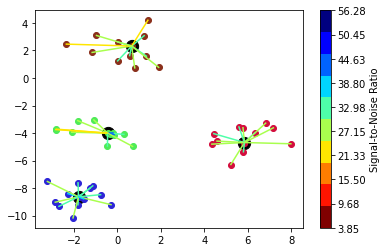

0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.306475


/home/iiitd/.local/lib/python3.8/site-packages/syft/frameworks/torch/hook/hook.py:560: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  current_tensor = hook_self.torch.native_tensor(*args, **kwargs)
/home/iiitd/.local/lib/python3.8/site-packages/syft/frameworks/torch/tensors/interpreters/native.py:414: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  response = command_method(*args_, **kwargs_)
/home/iiitd/.local/lib/python3.8/site-packages/syft/generic/frameworks/hook/hook.py:165: UserWarning: This overload of sub_ is deprecated:
	sub_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	sub_(Tensor other, *, Number alpha) (Triggered internally at  /opt/conda/conda-bld/pytorch_1595629411241/work/torch/csrc/utils/python_arg_parser

Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.294335
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.279569

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.373436


/tmp/ipykernel_676634/1497942811.py:66: RuntimeWarning: invalid value encountered in true_divide
  key_np_received=(key_np_received/(h)).real


Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.310505
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.254033

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.252254
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.291999
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.299055

Power Allocated= 7.320287621771363
CSI= 0.8360161781488303
SNR= 30.525244237753967
Client: client17
Model client17 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.335025
Model client17 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.278104
Model client17 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.302535

Power Allocated= 7.160315411654493
CSI= 0.7373971574126553
SNR= 44.00226896076398
Client: client22
Model client22 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.310765
Model client22 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.279788
Model client22 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.286625

Power Allocated= 7.118829347902831
CSI= 0.715508

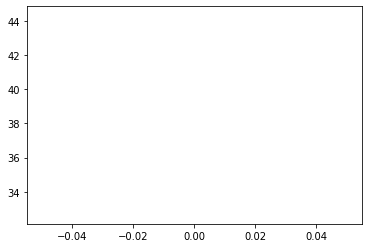

ROUND 0
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.303515
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.294783
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.302485

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.305635
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.300048
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.286424

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.300211
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.298357
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 2

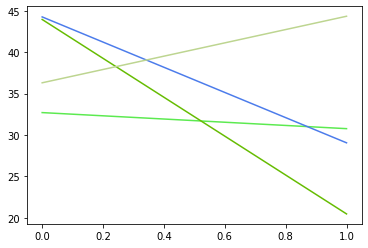

ROUND 1
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.300637
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.294271
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.298390

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.302543
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.298104
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.277206

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.300867
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.296558
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 2

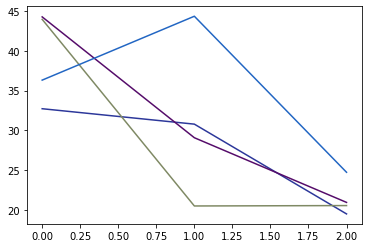

ROUND 2
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.301095
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.292663
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.283118

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.299047
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.287771
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.248249

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.302540
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.285813
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 2

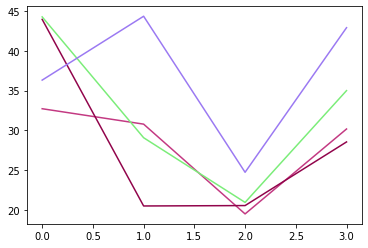

ROUND 3
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.298239
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.253506
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 2.069470

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.299219
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.272250
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.914739

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.302649
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.268126
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 2

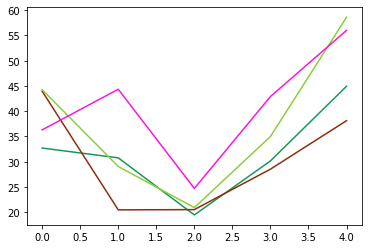

ROUND 4
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.271350
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.118279
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.548995

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.273417
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.054754
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.686684

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.272401
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.043974
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 1

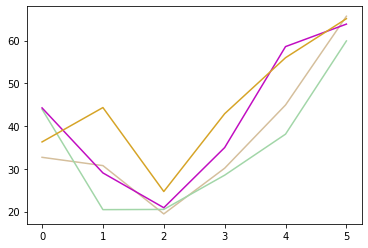

ROUND 5
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.260799
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.143517
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.781702

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.248275
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.117514
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.659510

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.262959
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.156828
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 1

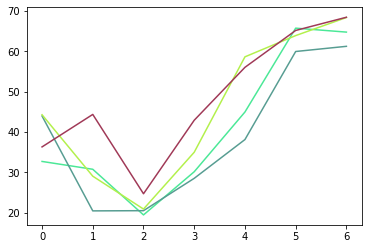

ROUND 6
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.267664
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.001112
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.683431

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.276189
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.009129
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.622984

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.253777
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.066450
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 1

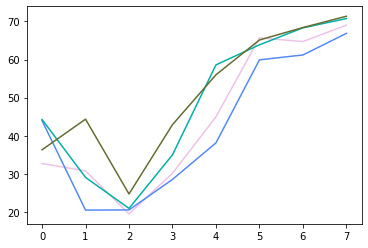

ROUND 7
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.247648
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.070294
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.836735

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.259073
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.057768
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.546752

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.245852
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.073411
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 1

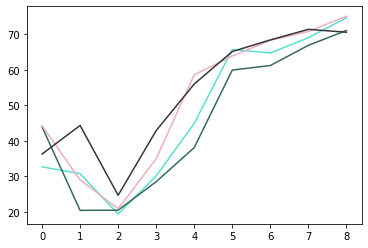

ROUND 8
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.223458
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.058915
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.785356

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.227507
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.787242
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.765082

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.230632
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.840986
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 1

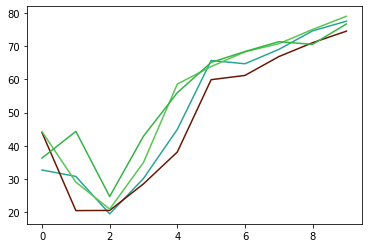

ROUND 9
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.223392
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.876580
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.414148

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.241629
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.036639
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.498613

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.215864
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.068963
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 1

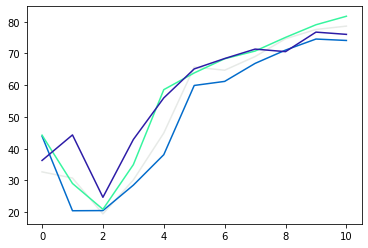

ROUND 10
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.249744
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 2.102759
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.900148

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.200846
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.857429
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.299842

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.217332
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.792677
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 

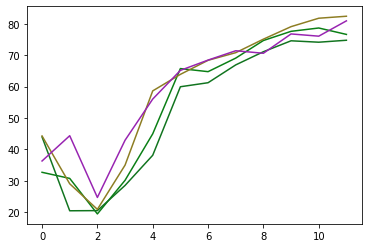

ROUND 11
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.221827
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.878515
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.152463

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.194112
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.590667
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.283895

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.204154
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.857549
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 

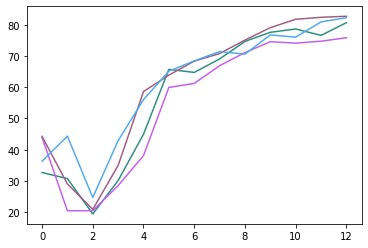

ROUND 12
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.190423
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.539521
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.905164

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.166089
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.660616
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.642171

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.195062
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.630484
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 

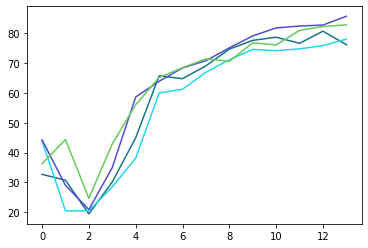

ROUND 13
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.140557
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.495538
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.249575

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.091313
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.591613
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.181610

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.137201
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.677136
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 

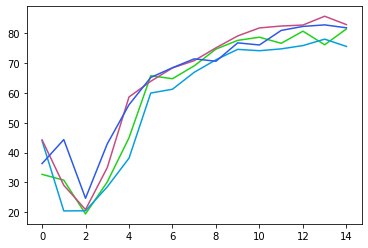

ROUND 14
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.111462
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.399118
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.830489

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.125633
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.744668
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.111177

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.105736
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.606426
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 

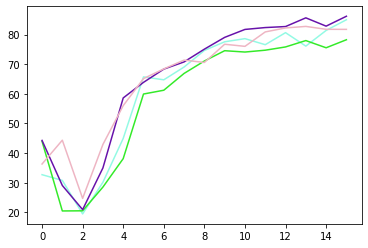

ROUND 15
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.070649
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.937682
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.223311

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.063704
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.176757
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.197105

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 2.064472
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.491244
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 

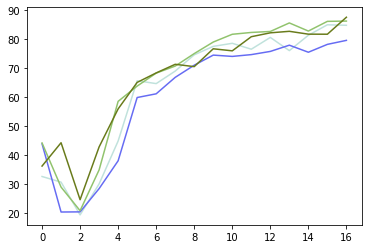

ROUND 16
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.967968
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.406589
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.168719

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.927626
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.186466
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.774048

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.967241
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.187659
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 

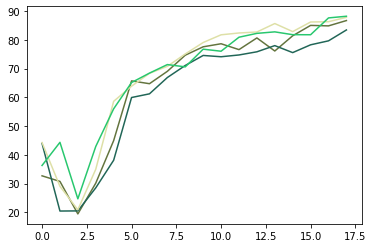

ROUND 17
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.911164
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.180663
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.071301

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.969824
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.149545
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.363886

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.930990
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.465820
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 

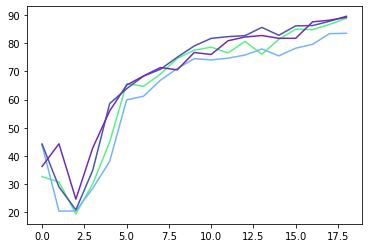

ROUND 18
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.828371
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.271455
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.100123

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.911454
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.043711
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.191190

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.868691
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.129071
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 

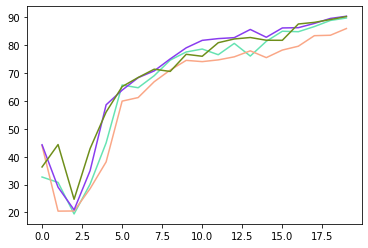

ROUND 19
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.902280
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.982707
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.321466

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.892531
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.881425
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.168837

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.814969
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.736005
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 

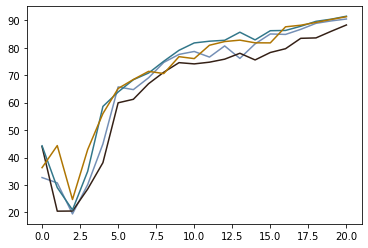

ROUND 20
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.817388
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.697897
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.579231

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.691999
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.794070
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.263736

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.609304
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.016440
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 

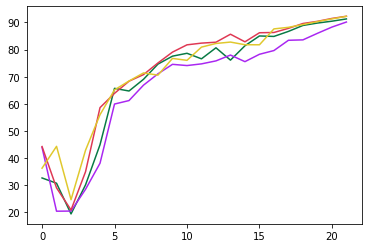

ROUND 21
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.828939
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.742646
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.460236

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.643343
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 1.064969
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.041337

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.633494
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.936143
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 

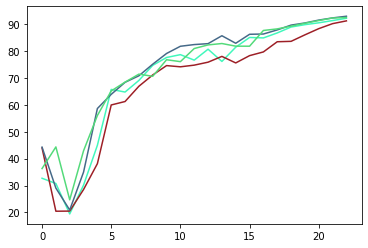

ROUND 22
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.666202
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.631676
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.765101

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.692262
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.931854
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.550095

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.682528
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.817706
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 

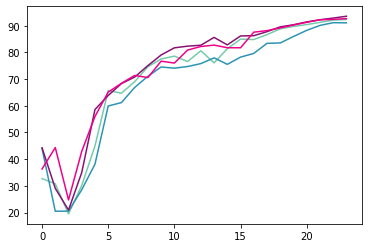

ROUND 23
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.631217
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.836739
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.583642

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.539934
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.696490
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.648976

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.635337
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.738435
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 

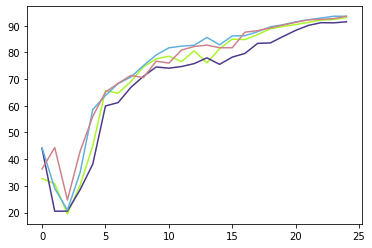

ROUND 24
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.513061
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.466659
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.452039

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.550695
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.648665
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.469399

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.511943
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.474675
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 

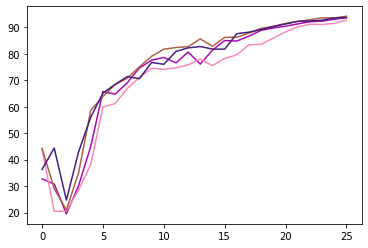

ROUND 25
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.493988
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.741105
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.485102

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.560801
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.683997
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.389485

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.423654
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.562726
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 

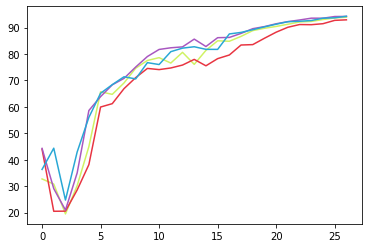

ROUND 26
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.357777
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.419630
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.613892

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.400585
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.414731
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.233892

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.300033
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.634592
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 

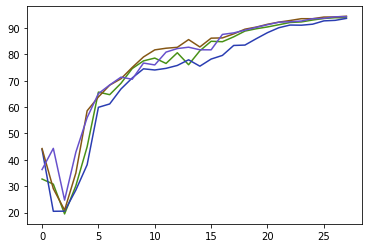

ROUND 27
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.592804
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.621553
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.289892

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.325740
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.450650
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.608704

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.400109
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.558365
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 

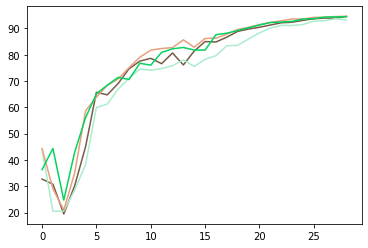

ROUND 28
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.269163
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.598627
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.990721

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.356726
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.354554
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.980742

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.241465
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.614850
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 

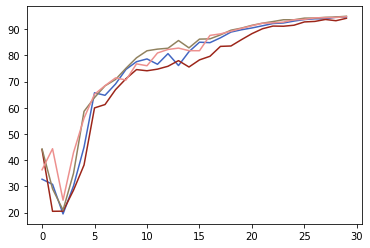

ROUND 29
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.121181
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.476952
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.019228

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.351199
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.438364
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.472833

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.170606
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.336498
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 

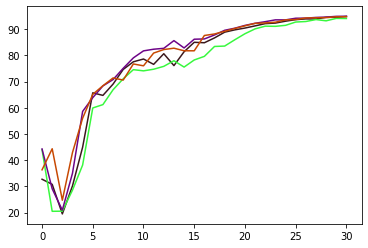

ROUND 30
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.183858
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.400325
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.364432

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.234410
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.227313
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.514709

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.127118
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.248535
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 

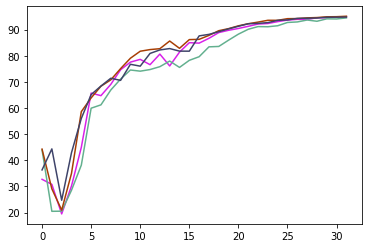

ROUND 31
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.205862
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.282059
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.494084

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.090828
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.355232
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.257812

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.103179
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.396086
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 

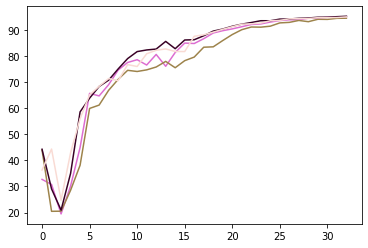

ROUND 32
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.069246
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.395475
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.398005

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.114604
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.300434
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.314193

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.117434
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.292403
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 

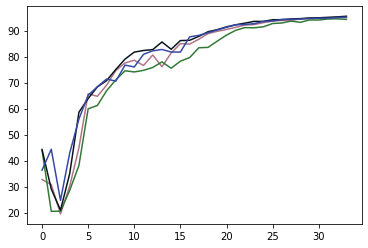

ROUND 33
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.062343
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.345031
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.364853

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.160966
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.221275
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.583316

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.091423
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.339868
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 

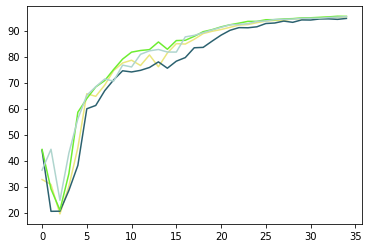

ROUND 34
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.131907
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.301834
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.190825

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.058463
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.324542
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.342227

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.933733
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.383699
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 

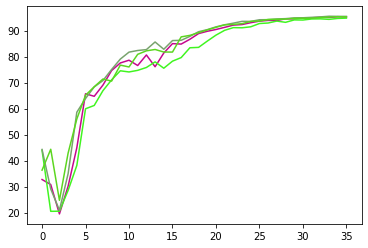

ROUND 35
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.004544
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.308855
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.338669

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.007746
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.276513
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.189905

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.025308
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.190481
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 

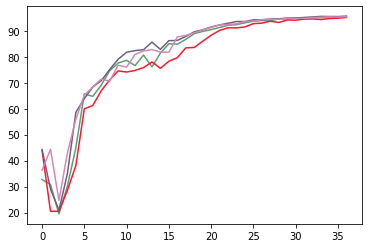

ROUND 36
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.942979
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.281169
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.435599

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.823987
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.270607
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.317866

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.885665
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.244757
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 

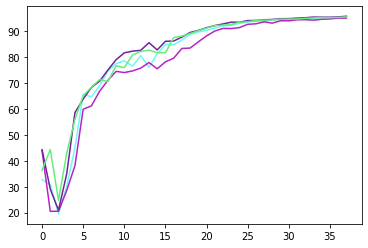

ROUND 37
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.889545
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.262021
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.574450

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.896878
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.176723
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.356643

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.987860
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.216409
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 

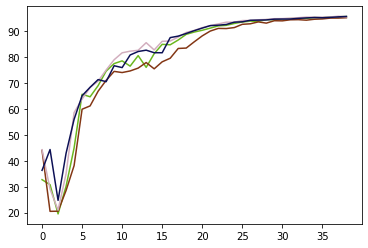

ROUND 38
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.845136
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.196771
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.203930

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.922141
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.284557
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.182549

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.961857
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.161398
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 

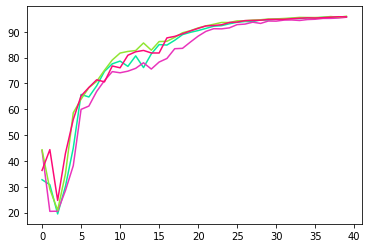

ROUND 39
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.818230
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.172236
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.275634

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.907286
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.212857
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.633268

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.860724
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.244350
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 

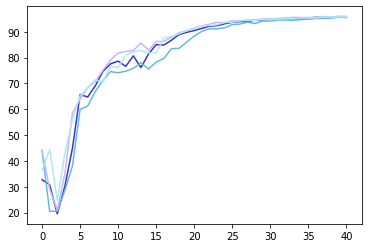

ROUND 40
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.786090
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.273511
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.456388

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.910811
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.164555
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.269792

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.906156
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.362076
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 

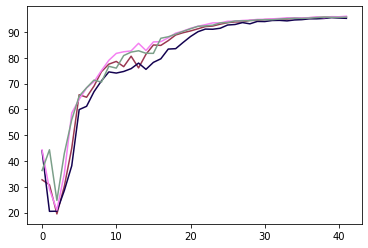

ROUND 41
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.820116
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.370892
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.708119

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.879117
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.486528
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.539126

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.807917
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.423253
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 

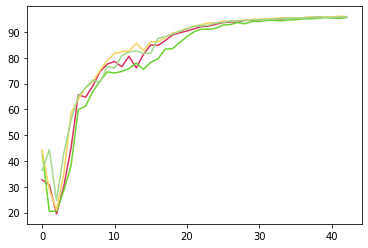

ROUND 42
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.769139
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.320724
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.339670

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.882962
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.189976
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.592401

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.763264
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.257333
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 

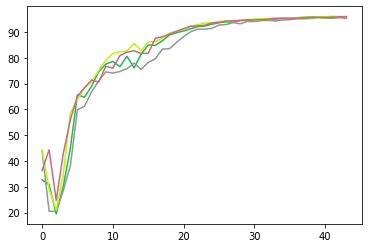

ROUND 43
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.929428
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.397304
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.598455

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.847036
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.354390
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.175810

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.834948
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.280261
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 

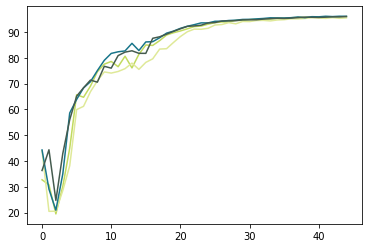

ROUND 44
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.680160
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.539696
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.967797

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 1.008893
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.175155
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.353851

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.783248
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.253549
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 

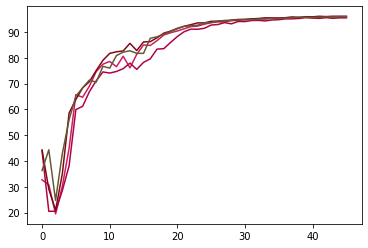

ROUND 45
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.797788
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.194872
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.225898

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.810968
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.276444
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.155065

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.771953
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.206470
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 

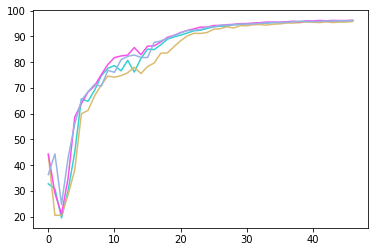

ROUND 46
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.872105
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.228203
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.958468

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.881577
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.236816
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.278617

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.819628
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.363725
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 

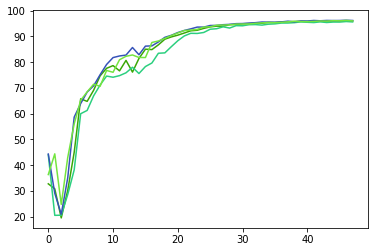

ROUND 47
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.775950
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.176541
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.789329

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.896405
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.222761
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.587458

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.816537
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.169603
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 

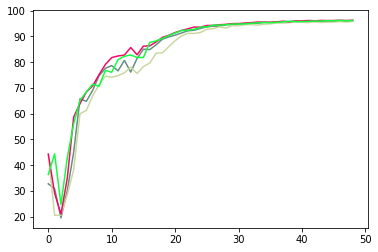

ROUND 48
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.843584
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.434011
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.595551

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.834391
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.288957
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.336390

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.715619
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.235723
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 

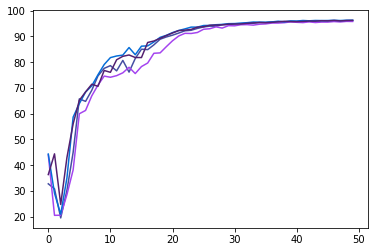

ROUND 49
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.897210
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.399495
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.799423

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.765026
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.203817
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.140509

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.798985
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.284675
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 

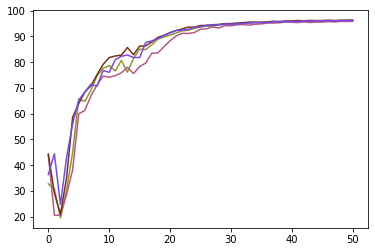

ROUND 50
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.636665
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.278128
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.091739

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.719835
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.234480
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.143761

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.714131
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.309949
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 

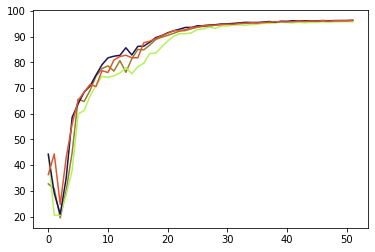

ROUND 51
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.705168
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.289294
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.387061

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.763121
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.170753
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.525188

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.723859
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.090806
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 

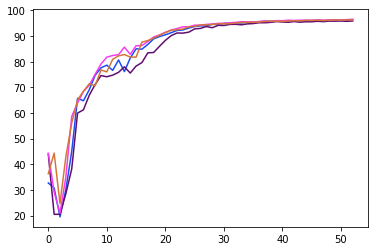

ROUND 52
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.937764
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.309720
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.140609

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.659011
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.296097
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.446167

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.821172
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.167678
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 

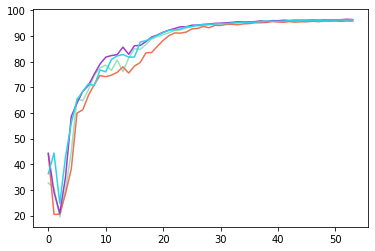

ROUND 53
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.682623
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.190174
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.381839

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.695240
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.164606
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.595532

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.785907
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.191572
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 

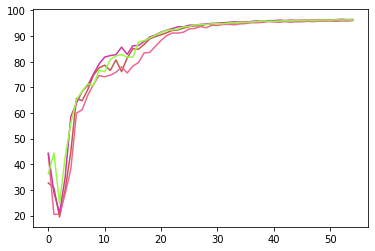

ROUND 54
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.728524
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.246695
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.139216

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.760713
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.277202
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.102989

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.770529
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.313615
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 

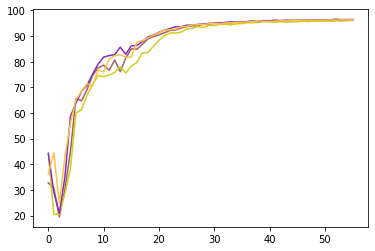

ROUND 55
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.625210
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.211434
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.371345

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.667997
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.076816
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.323312

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.602097
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.083897
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 

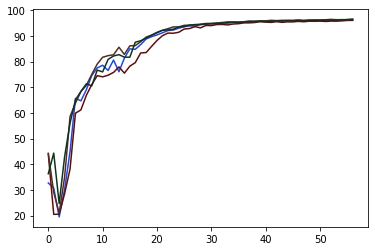

ROUND 56
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.811209
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.453423
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.457350

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.662742
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.094994
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.101539

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.715029
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.419829
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 

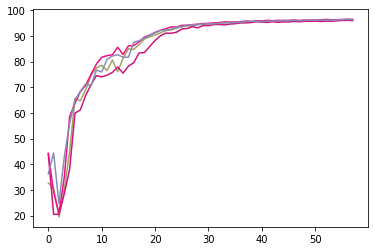

ROUND 57
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.617552
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.151743
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.198933

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.593045
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.189274
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.198700

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.805958
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.421198
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 

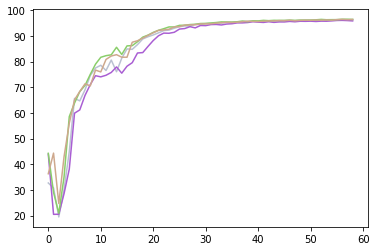

ROUND 58
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.816866
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.226439
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.981722

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.730103
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.211112
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.139247

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.764285
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.253329
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 

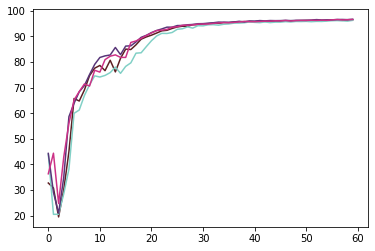

ROUND 59
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.626163
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.067022
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.075091

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.641723
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.197865
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.270495

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.723442
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.090863
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 

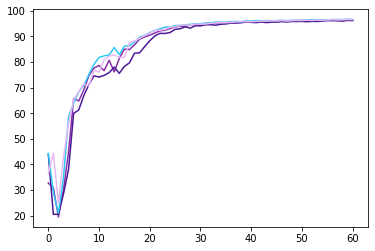

ROUND 60
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.652811
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.160669
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.773557

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.646773
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.182390
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.238280

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.724364
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.258236
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 

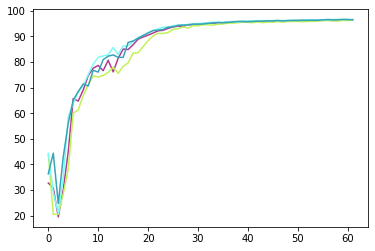

ROUND 61
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.676957
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.223169
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.732579

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.667124
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.180481
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.586499

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.647989
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.060351
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 

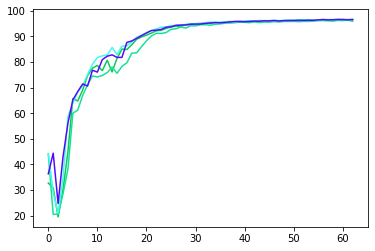

ROUND 62
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.655261
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.080557
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.125770

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.690148
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.216630
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.533077

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.658105
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.296614
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 

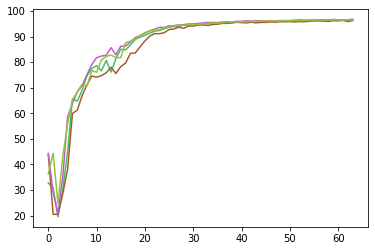

ROUND 63
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.690463
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.467234
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.490235

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.580050
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.106425
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.287329

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.731361
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.213106
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 

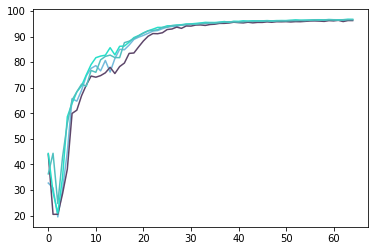

ROUND 64
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.634145
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.181021
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.100376

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.621704
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.381292
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.700641

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.421583
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.123642
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 

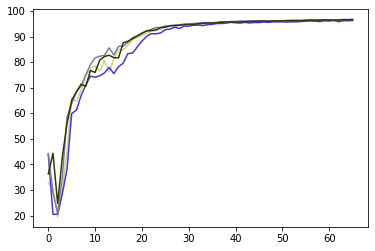

ROUND 65
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.674036
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.227050
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.275397

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.595993
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.344859
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.179245

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.556559
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.168014
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 

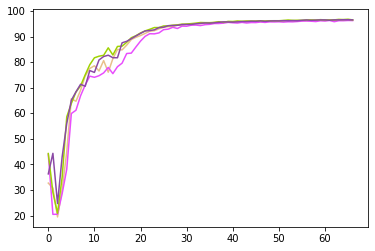

ROUND 66
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.586993
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.249794
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.592506

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.610627
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.260434
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.096361

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.662749
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.051390
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 

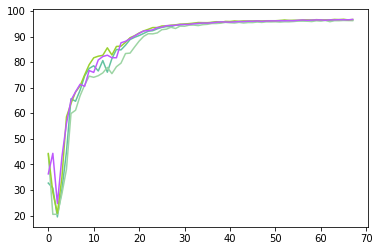

ROUND 67
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.490823
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.188382
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.119263

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.734548
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.223176
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.311586

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.669733
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.313659
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 

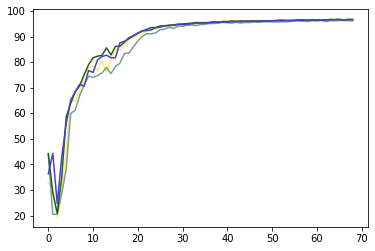

ROUND 68
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.714080
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.104219
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.218437

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.765594
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.116659
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.233668

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.570721
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.313941
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 

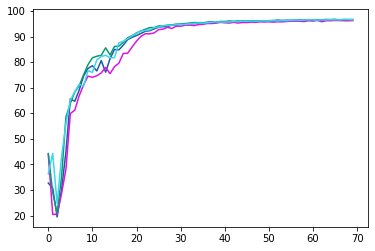

ROUND 69
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.643047
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.151071
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.309037

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.505095
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.200904
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.161625

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.580358
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.317429
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 

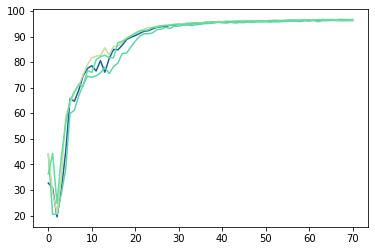

ROUND 70
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.686145
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.033039
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.095513

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.621772
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.182226
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.506057

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.722398
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.164615
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 

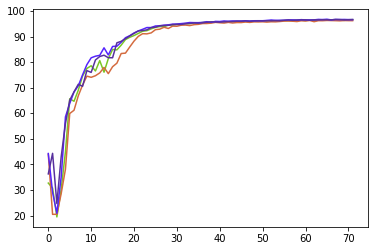

ROUND 71
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.662092
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.166924
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.161370

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.620937
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.200749
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.306227

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.695137
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.119400
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 

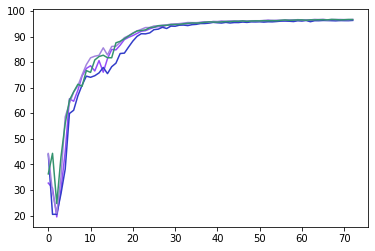

ROUND 72
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.645412
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.194291
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.778182

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.611303
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.136281
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.329228

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.626663
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.151277
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 

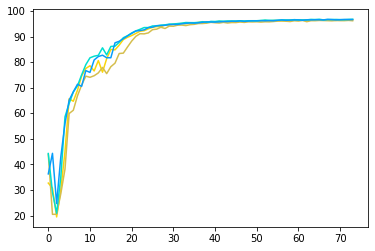

ROUND 73
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.482939
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.140862
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.108647

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.702504
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.182410
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.188730

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.531359
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.262695
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 

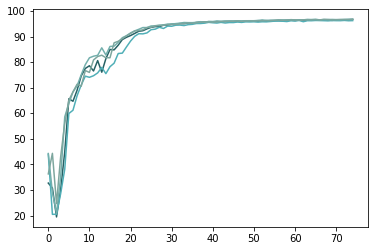

ROUND 74
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.750570
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.189194
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.701090

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.663516
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.242942
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.097597

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.578496
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.168827
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 

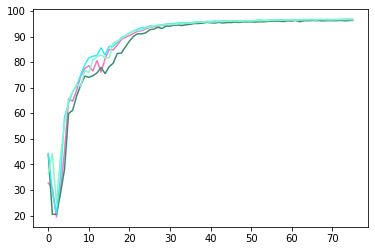

ROUND 75
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.613338
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.227163
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.681059

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.615556
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.085096
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.286206

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.738124
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.271356
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 

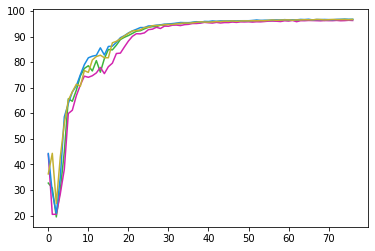

ROUND 76
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.601591
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.061725
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.074160

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.530863
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.481465
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.678955

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.602558
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.366989
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 

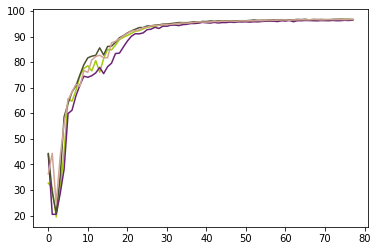

ROUND 77
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.513368
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.117841
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.591356

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.523600
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.121208
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.208084

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.664195
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.112819
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 

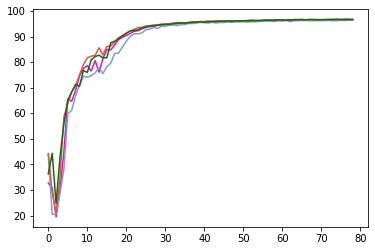

ROUND 78
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.630415
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.216706
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.339080

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.564407
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.244422
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.447403

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.567597
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.084367
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 

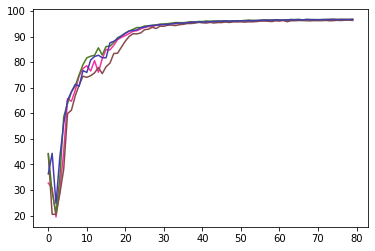

ROUND 79
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.703777
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.096719
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.580490

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.649151
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.263512
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.198573

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.668629
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.138122
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 

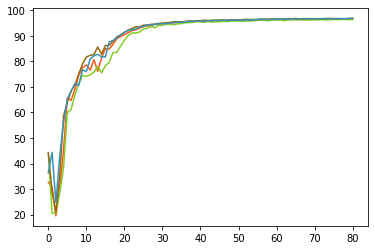

ROUND 80
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.609654
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.106661
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.405228

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.456896
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.282310
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.116933

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.598045
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.144442
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 

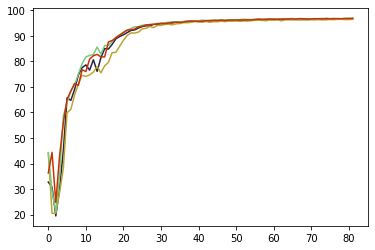

ROUND 81
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.621140
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.194088
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.205065

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.626926
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.187603
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.022698

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.391315
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.294006
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 

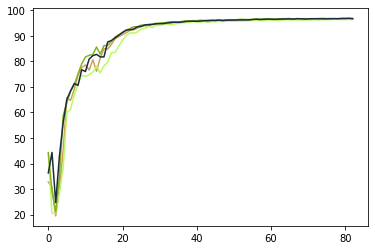

ROUND 82
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.656546
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.079055
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.050332

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.581979
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.162099
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.161137

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.515208
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.185273
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 

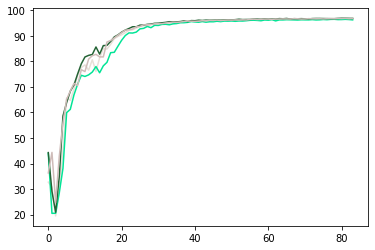

ROUND 83
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.541828
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.234176
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.218245

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.511385
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.114788
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.761139

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.693253
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.236513
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 

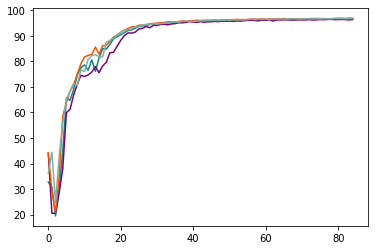

ROUND 84
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.435835
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.054810
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.608274

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.549996
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.262390
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.381773

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.690610
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.139206
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 

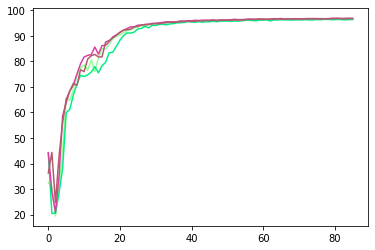

ROUND 85
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.483960
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.327373
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.720329

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.523776
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.160684
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.415364

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.443501
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.312828
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 

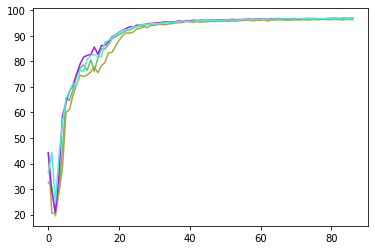

ROUND 86
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.478163
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.103143
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.285882

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.483916
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.066620
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.096103

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.619672
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.127753
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 

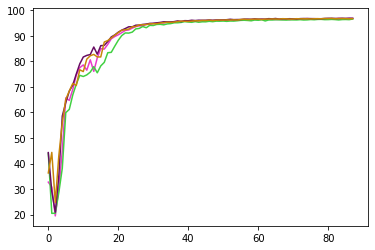

ROUND 87
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.463408
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.042154
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.434243

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.573771
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.080602
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.148020

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.563118
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.205042
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 

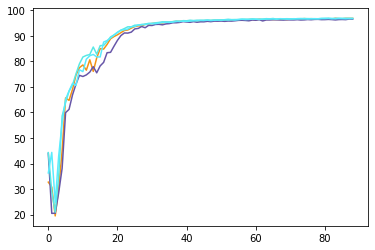

ROUND 88
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.509669
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.295256
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.433703

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.444202
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.334687
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.193084

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.502574
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.323753
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 

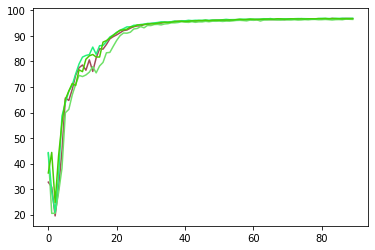

ROUND 89
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.411742
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.190389
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.492611

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.690150
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.359319
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.139515

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.603548
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.185920
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 

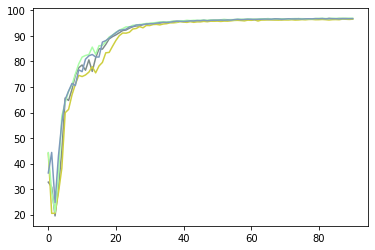

ROUND 90
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.507168
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.242030
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.784686

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.623693
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.247414
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.502444

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.578331
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.047735
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 

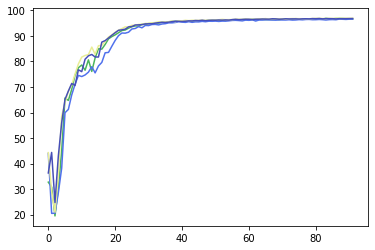

ROUND 91
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.549870
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.124641
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.582730

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.624482
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.136046
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.274895

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.658419
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.269490
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 

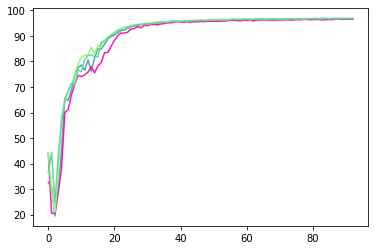

ROUND 92
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.500338
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.099032
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.404445

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.561950
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.290524
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.085658

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.567313
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.090156
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 

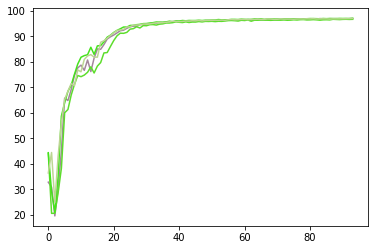

ROUND 93
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.527728
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.080291
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.697847

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.489898
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.076385
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.222851

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.595493
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.024149
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 

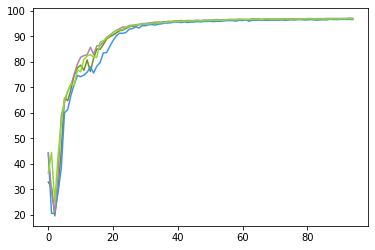

ROUND 94
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.485975
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.286681
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.181272

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.516385
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.142503
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.093511

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.463981
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.153129
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 

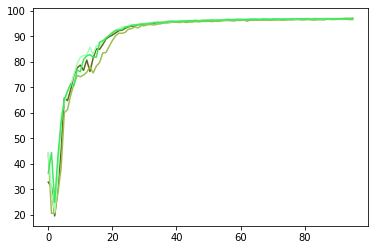

ROUND 95
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.484881
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.243203
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.026174

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.441912
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.035695
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.724691

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.525787
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.119666
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 

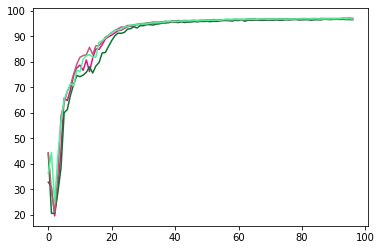

ROUND 96
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.536809
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.084368
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.747829

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.664513
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.069614
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.559616

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.566769
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.179674
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 

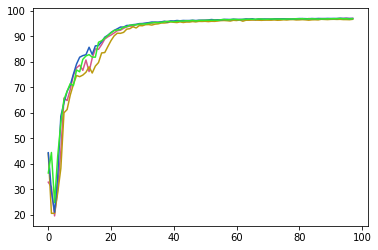

ROUND 97
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.666745
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.075513
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.141015

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.511119
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.364247
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.275399

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.562970
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.246827
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 

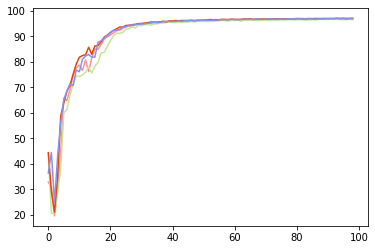

ROUND 98
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.536479
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.045197
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.177530

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.329711
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.191838
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.077973

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.439493
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.071385
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 

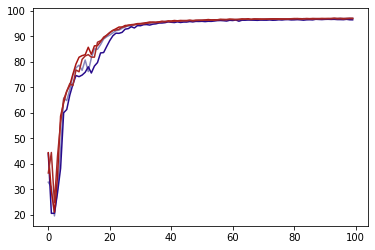

ROUND 99
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.463061
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.090510
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.125432

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.453396
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.224863
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.076488

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.633623
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.053139
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss: 

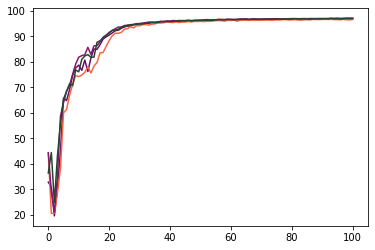

ROUND 100
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.496796
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.088948
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.042193

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.586367
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.047624
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.148972

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.446883
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.131716
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss:

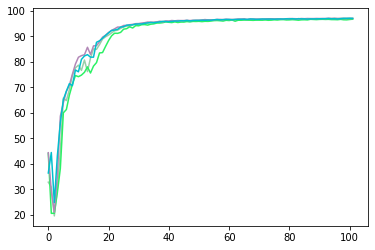

ROUND 101
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.494524
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.192062
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.171901

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.515592
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.065916
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.243904

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.477458
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.062193
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss:

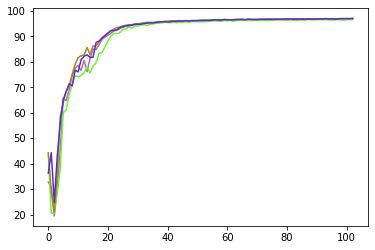

ROUND 102
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.488188
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.136227
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.751481

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.545293
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.066066
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.049406

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.405188
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.163768
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss:

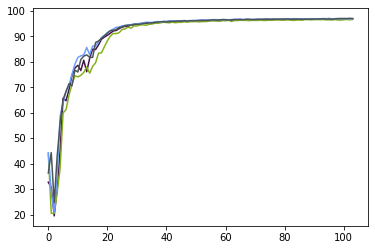

ROUND 103
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.579633
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.165812
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.331263

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.478622
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.082511
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.603173

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.434719
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.272358
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss:

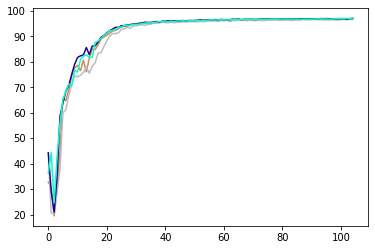

ROUND 104
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.471051
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.163287
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.110100

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.439083
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.088027
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.389999

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.413429
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.119057
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss:

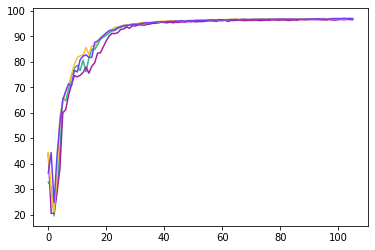

ROUND 105
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.542929
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.130086
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.219747

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.633221
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.103896
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.017389

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.390152
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.119583
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss:

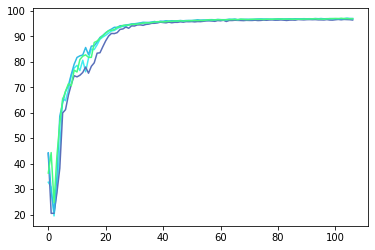

ROUND 106
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.531542
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.083730
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.430829

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.455760
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.227694
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.562229

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.602138
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.125247
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss:

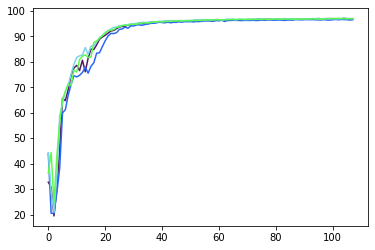

ROUND 107
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.499813
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.115933
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.242195

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.434270
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.111765
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.356052

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.604597
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.154763
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss:

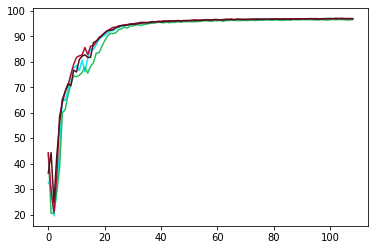

ROUND 108
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.536781
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.207942
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.088096

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.697808
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.141998
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.079183

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.378782
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.039647
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss:

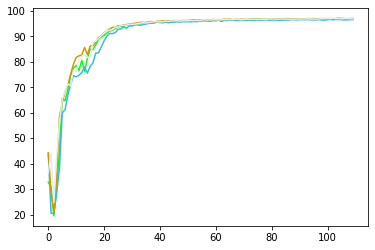

ROUND 109
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.478674
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.183020
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.063209

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.573707
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.040216
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.150535

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.378947
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.096756
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss:

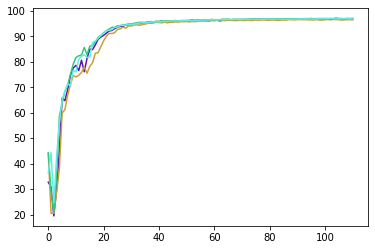

ROUND 110
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.433148
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.067255
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.325697

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.497543
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.158233
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.302570

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.683666
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.037673
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss:

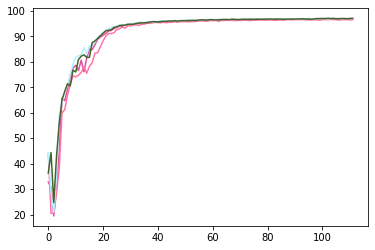

ROUND 111
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.727612
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.120500
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.649113

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.510271
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.117447
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.205696

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.630277
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.034917
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss:

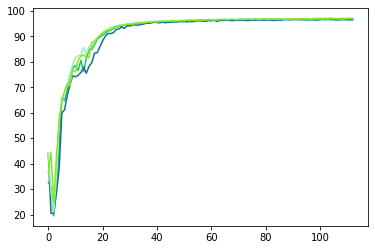

ROUND 112
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.473926
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.088680
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.110005

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.389606
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.070371
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.073674

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.531517
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.159239
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss:

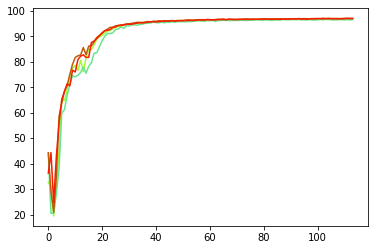

ROUND 113
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.392592
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.048040
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.189386

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.433456
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.043667
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.144833

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.502327
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.329089
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss:

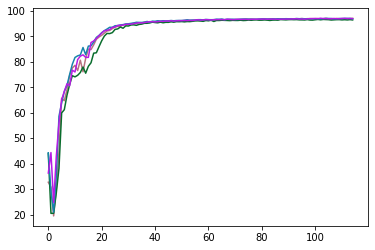

ROUND 114
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.388104
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.095101
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.059979

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.428285
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.133859
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.047806

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.499740
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.118064
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss:

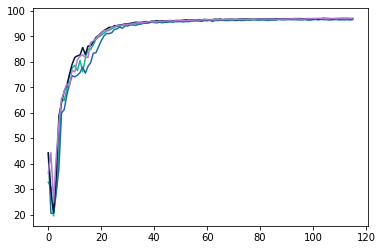

ROUND 115
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.541893
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.180044
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.082122

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.494038
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.083937
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.076978

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.524186
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.340061
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss:

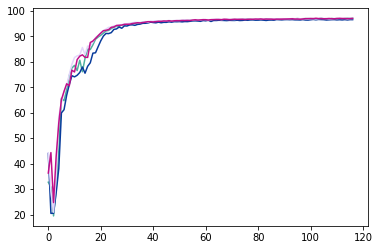

ROUND 116
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.391789
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.172277
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.148719

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.571932
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.182835
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.112729

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.536434
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.207919
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss:

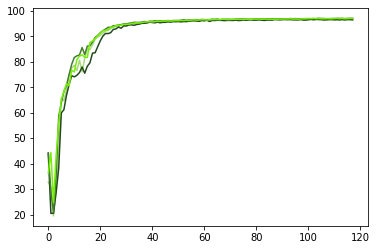

ROUND 117
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.445469
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.206630
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.935870

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.639062
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.308452
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.108657

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.489755
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.206932
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss:

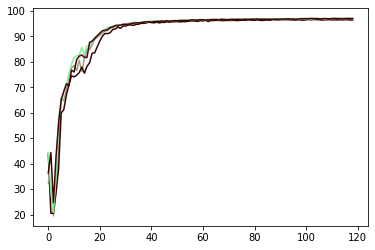

ROUND 118
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.445073
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.227316
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.230820

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.355389
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.200808
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.390643

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.489574
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.082058
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss:

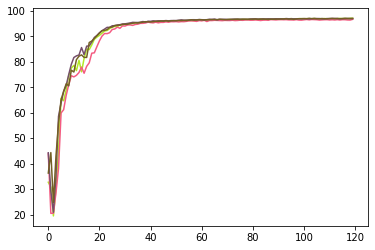

ROUND 119
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.418797
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.087152
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.206301

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.412274
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.099548
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.197347

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.509255
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.177177
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss:

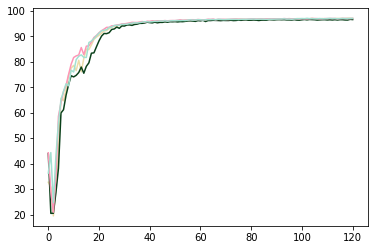

ROUND 120
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.459766
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.065200
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.954984

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.467137
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.077878
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.414387

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.409955
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.113161
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss:

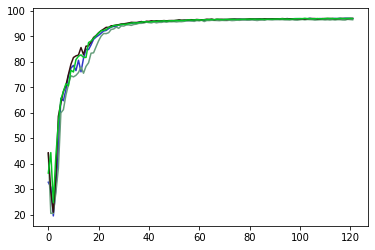

ROUND 121
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.484363
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.013754
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.326960

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.523903
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.037288
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.249782

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.397119
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.133701
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss:

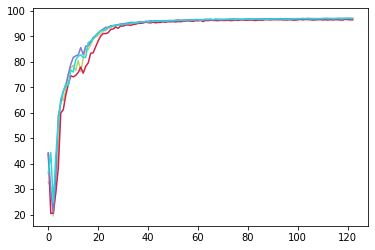

ROUND 122
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.361140
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.038822
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.551300

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.568531
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.176398
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.219847

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.509109
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.209488
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss:

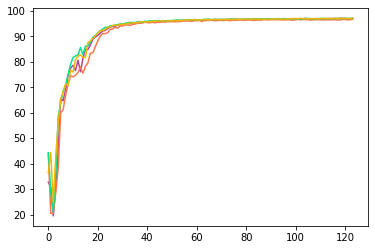

ROUND 123
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.451645
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.131421
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.133816

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.471924
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.073185
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.452558

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.434811
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.101665
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss:

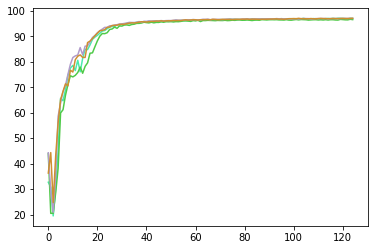

ROUND 124
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.435474
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.102698
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.058342

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.513757
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.130244
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.445121

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.496799
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.213829
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss:

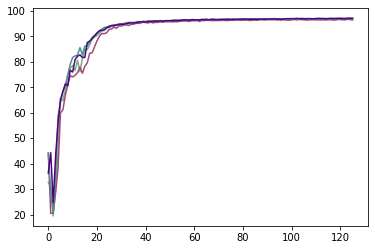

ROUND 125
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.321713
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.136816
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.158732

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.441444
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.035159
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.226974

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.478098
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.216568
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss:

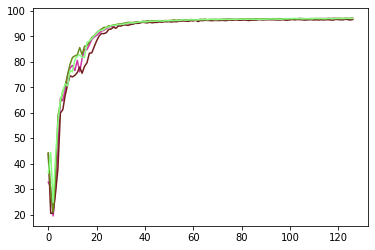

ROUND 126
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.486807
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.232138
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.309381

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.468674
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.211358
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.193810

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.528711
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.091587
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss:

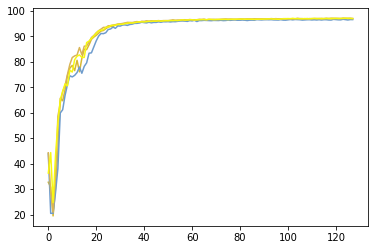

ROUND 127
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.386565
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.068813
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.029028

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.271547
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.172142
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.009351

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.366174
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.092972
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss:

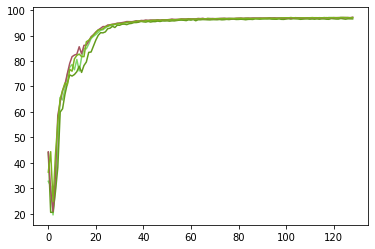

ROUND 128
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.584768
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.081445
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.069310

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.562604
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.116598
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.279779

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.430129
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.083453
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss:

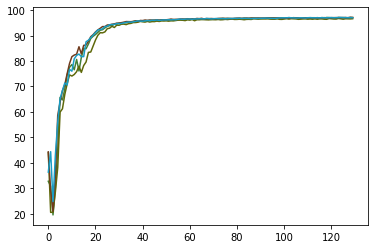

ROUND 129
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.497579
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.074970
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.245440

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.552444
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.039396
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.155602

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.413555
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.050987
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss:

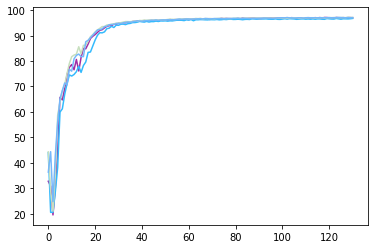

ROUND 130
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.447472
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.130052
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.948391

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.408811
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.160734
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.010186

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.405154
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.105062
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss:

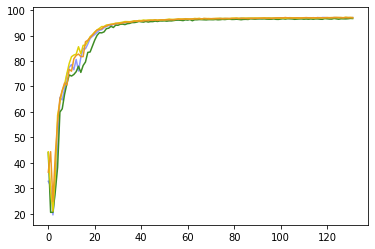

ROUND 131
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.368343
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.268961
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.017448

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.349099
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.142565
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.203044

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.517097
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.027038
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss:

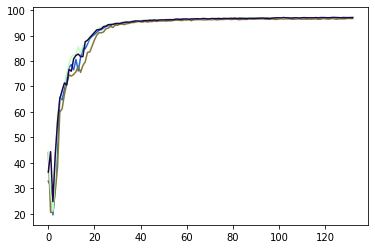

ROUND 132
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.417913
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.105517
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.098409

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.412670
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.173228
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.295192

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.436857
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.125207
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss:

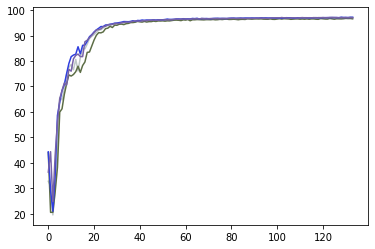

ROUND 133
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.467600
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.097503
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.080758

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.487887
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.145412
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.144307

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.380390
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.159081
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss:

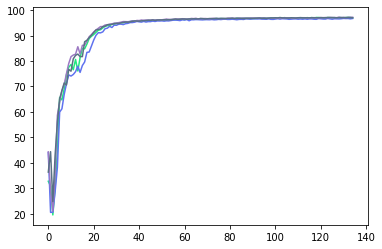

ROUND 134
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.384162
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.119049
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.102782

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.444319
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.061257
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.264612

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.361905
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.072929
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss:

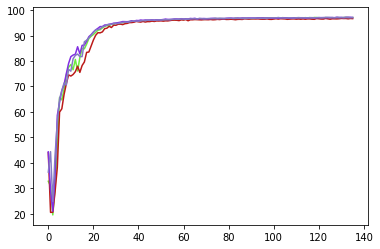

ROUND 135
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.521652
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.180029
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.056481

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.445089
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.048779
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.306323

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.495732
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.127264
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss:

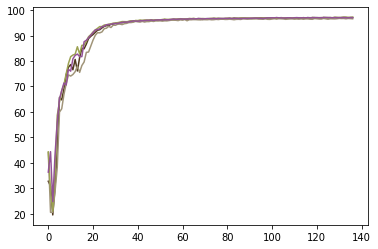

ROUND 136
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.514786
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.224906
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.310216

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.346128
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.109748
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.153362

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.531025
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.223356
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss:

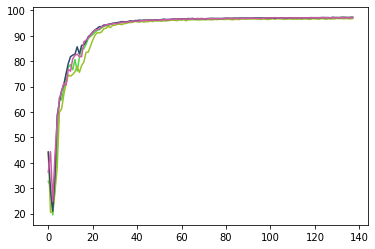

ROUND 137
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.461248
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.140298
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.206859

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.510723
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.092463
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.204416

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.488525
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.138361
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss:

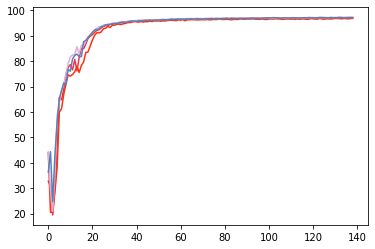

ROUND 138
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.389725
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.100539
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.221417

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.459048
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.030418
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.056236

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.577768
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.055002
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss:

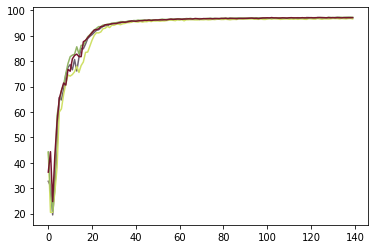

ROUND 139
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.380676
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.069301
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.084223

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.278608
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.059792
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.174716

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.422475
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.246775
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss:

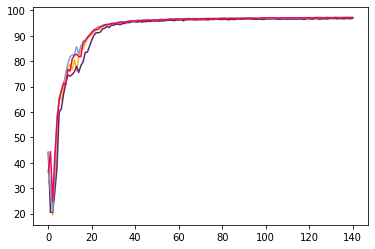

ROUND 140
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.481081
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.048147
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.087825

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.437746
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.113553
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.152808

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.411824
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.208428
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss:

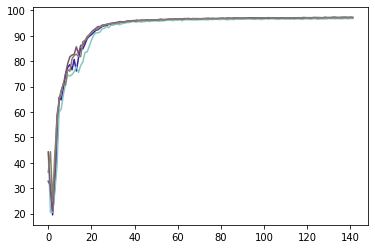

ROUND 141
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.539265
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.002190
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.221067

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.380783
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.263593
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.382493

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.367718
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.120935
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss:

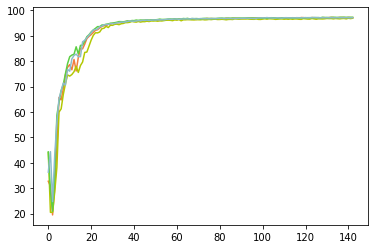

ROUND 142
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.356354
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.085556
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.748628

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.425506
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.157321
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.200548

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.586269
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.099055
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss:

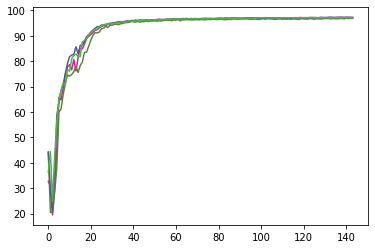

ROUND 143
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.460510
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.207984
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.365689

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.483237
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.105744
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.057074

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.422660
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.092351
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss:

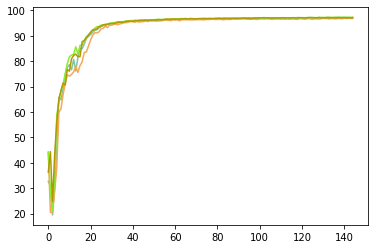

ROUND 144
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.419095
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.090897
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.283886

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.448101
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.266815
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.094696

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.462449
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.124699
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss:

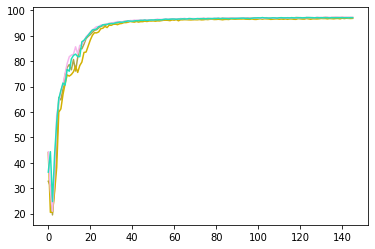

ROUND 145
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.305344
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.053593
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.179769

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.507768
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.047017
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.020106

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.412086
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.065591
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss:

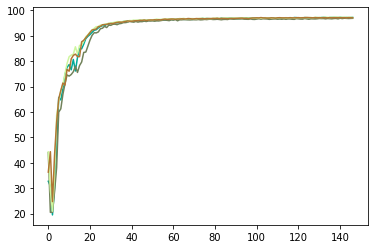

ROUND 146
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.620607
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.015495
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.015356

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.369610
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.305301
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.673198

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.510636
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.027094
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss:

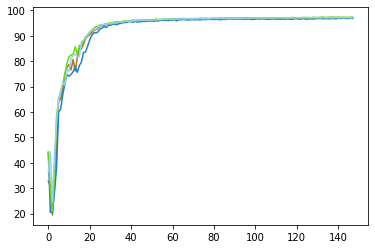

ROUND 147
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.402268
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.179188
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.258454

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.435873
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.028216
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.375890

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.340145
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.062311
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss:

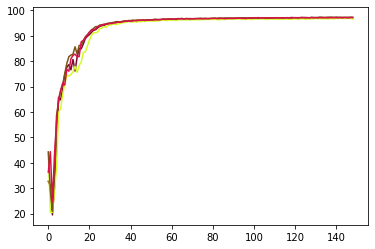

ROUND 148
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.466842
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.017646
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.706018

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.465258
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.032061
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.541176

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.469287
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.036240
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss:

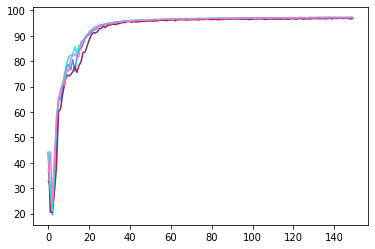

ROUND 149
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.363543
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.065351
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.023055

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.340041
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.151280
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.208766

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.424503
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.028036
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss:

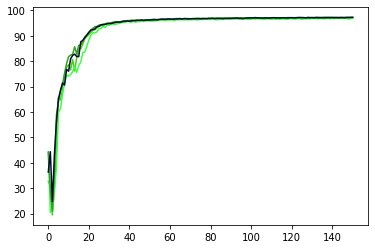

ROUND 150
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.444918
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.058654
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.010141

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.457216
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.123850
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.027012

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.538146
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.160498
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss:

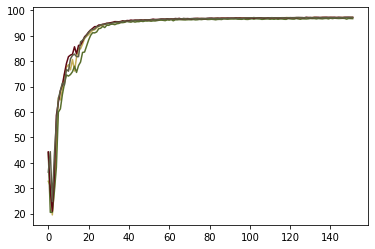

ROUND 151
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.463620
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.114547
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.174687

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.480000
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.098197
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.495730

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.496381
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.174775
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss:

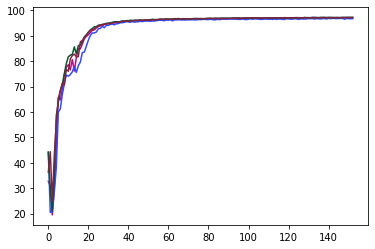

ROUND 152
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.358661
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.168093
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.566649

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.357326
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.108588
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.006791

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.403892
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.030777
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss:

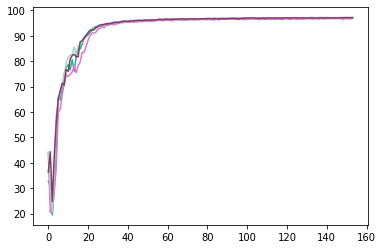

ROUND 153
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.496683
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.244103
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.631170

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.367597
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.112875
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.161526

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.442451
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.066695
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss:

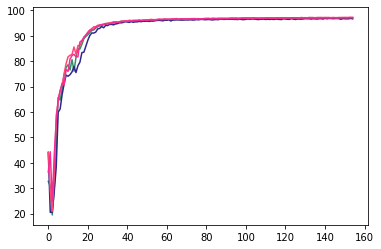

ROUND 154
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.617464
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.114156
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.249695

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.475864
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.158858
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.029526

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.534472
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.154081
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss:

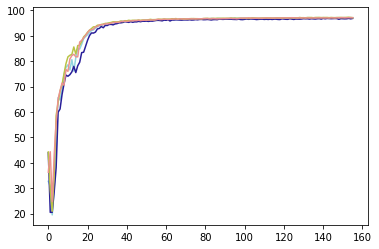

ROUND 155
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.522167
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.106300
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.046286

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.430087
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.097461
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.174784

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.485114
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.107802
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss:

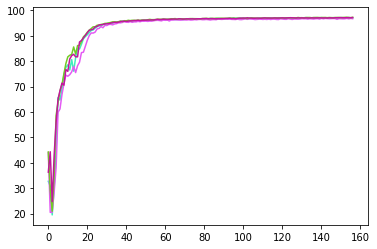

ROUND 156
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.595184
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.086194
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.022290

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.371781
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.551752
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.132635

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.373734
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.288857
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss:

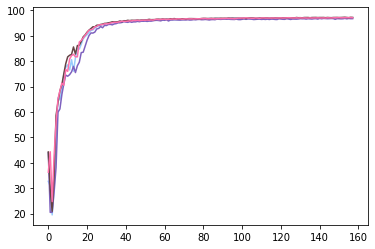

ROUND 157
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.463353
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.165060
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.035017

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.420784
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.116047
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.267783

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.577547
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.030873
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss:

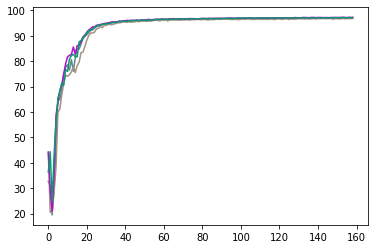

ROUND 158
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.461233
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.127915
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.540541

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.365761
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.011280
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 1.005827

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.342666
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.021888
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss:

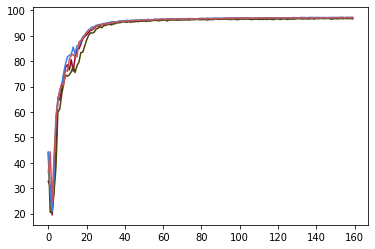

ROUND 159
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.398324
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.096218
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.045601

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.303085
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.379919
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.033118

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.406214
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.070646
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss:

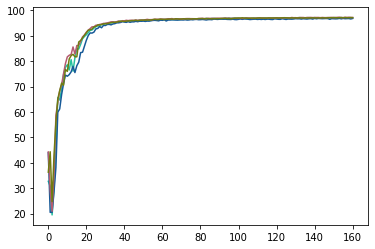

ROUND 160
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.437479
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.032439
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.193763

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.332776
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.097688
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.074384

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.456870
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.104980
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss:

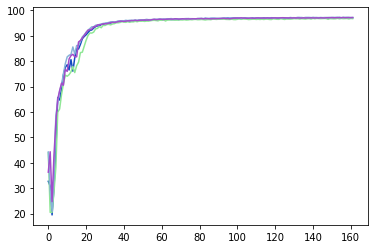

ROUND 161
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.490738
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.067225
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.068850

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.497747
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.122981
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.061033

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.351005
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.255801
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss:

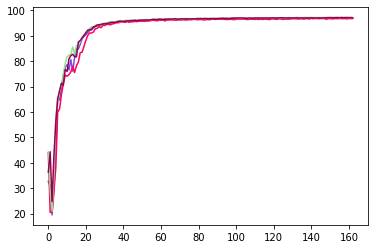

ROUND 162
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.567890
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.052133
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.068647

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.277712
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.129236
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.010403

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.359914
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.117971
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss:

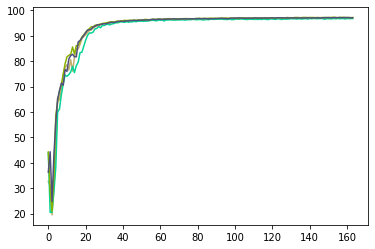

ROUND 163
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.345933
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.043860
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.116032

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.456762
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.149962
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.095732

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.367649
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.119486
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss:

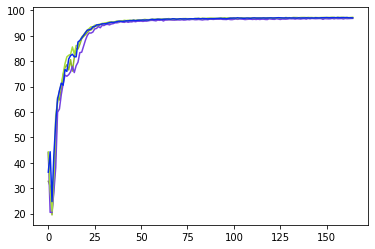

ROUND 164
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.447836
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.130505
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.433542

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.335325
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.096603
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.539212

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.372191
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.072688
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss:

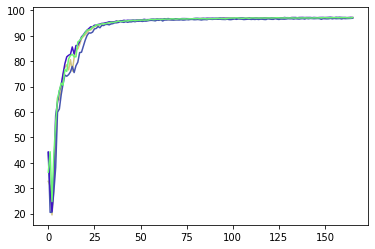

ROUND 165
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.353953
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.111965
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.267808

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.437513
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.095556
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.032541

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.455133
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.176437
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss:

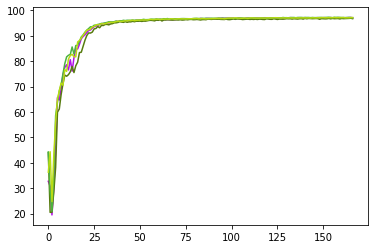

ROUND 166
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.406510
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.161363
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.165752

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.508090
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.119925
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.095792

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.469596
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.073063
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss:

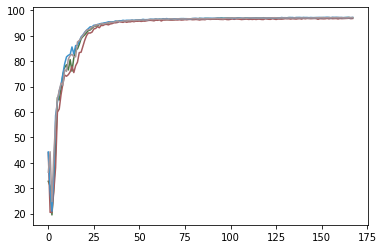

ROUND 167
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.480442
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.149738
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.315527

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.315069
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.023606
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.027673

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.362948
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.071520
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss:

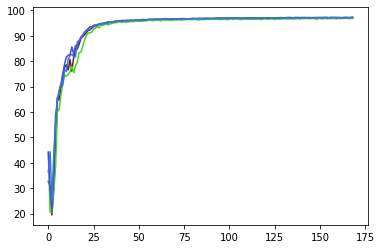

ROUND 168
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.386102
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.197098
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.138460

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.410255
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.074444
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.051484

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.348974
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.037394
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss:

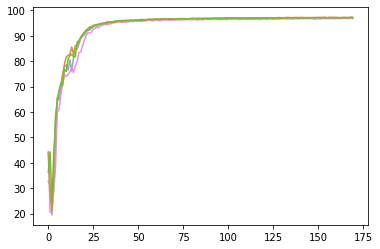

ROUND 169
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.416677
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.165329
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.416107

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.281177
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.130637
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.719512

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.415538
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.092293
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss:

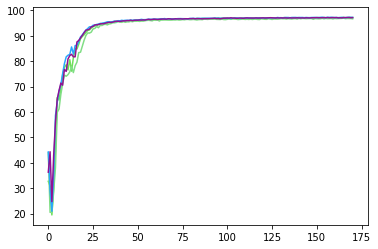

ROUND 170
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.341083
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.024052
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.473927

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.517046
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.053214
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.330826

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.375445
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.160031
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss:

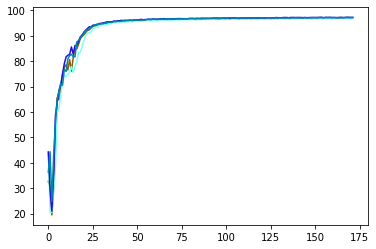

ROUND 171
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.325626
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.150413
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.245520

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.427081
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.134032
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.326404

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.393822
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.218519
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss:

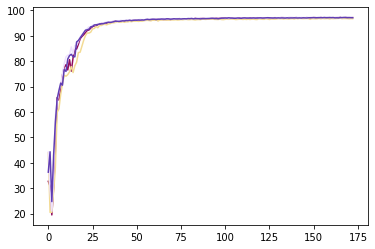

ROUND 172
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.320656
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.025271
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.031526

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.521773
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.084289
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.200779

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.322259
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.041778
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss:

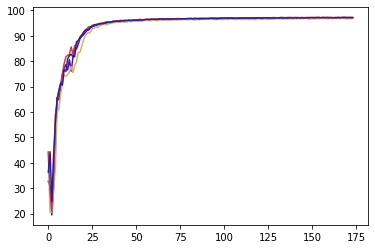

ROUND 173
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.457014
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.219003
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.438752

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.435226
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.046229
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.093448

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.363181
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.095397
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss:

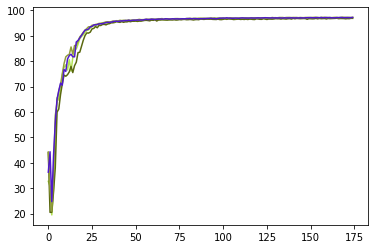

ROUND 174
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.461179
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.140689
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.257563

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.372558
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.031006
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.170233

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.352592
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.124634
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss:

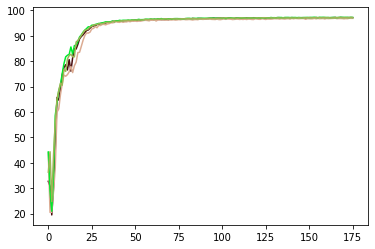

ROUND 175
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.455790
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.080482
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.104728

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.463883
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.255349
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.154598

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.437832
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.123150
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss:

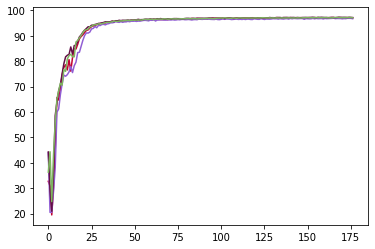

ROUND 176
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.489934
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.081734
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.438592

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.375587
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.079614
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.204011

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.422687
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.062648
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss:

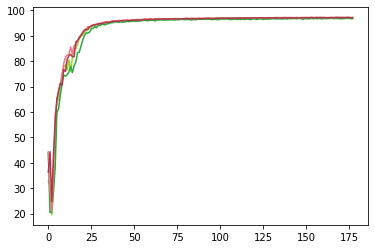

ROUND 177
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.274529
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.021699
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.171555

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.472259
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.018095
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.091486

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.505510
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.075290
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss:

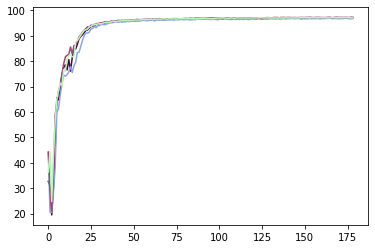

ROUND 178
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.457282
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.084575
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.252278

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.345047
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.112323
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.115028

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.298816
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.282133
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss:

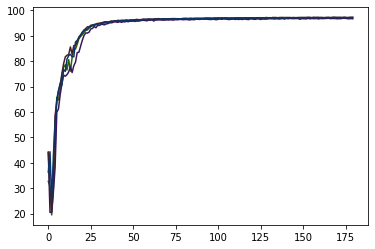

ROUND 179
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.506052
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.153388
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.389293

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.275124
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.137886
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.070905

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.378136
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.086143
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss:

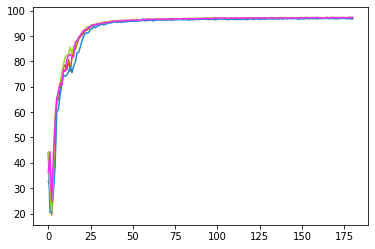

ROUND 180
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.381962
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.115514
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.204614

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.346529
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.074989
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.049907

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.454396
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.072679
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss:

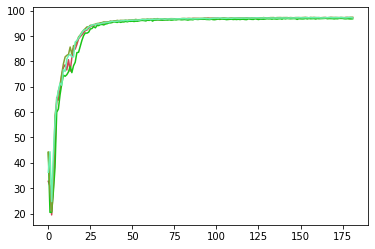

ROUND 181
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.410058
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.107605
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.399644

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.435727
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.124936
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.224973

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.424097
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.107221
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss:

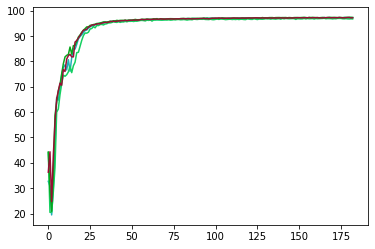

ROUND 182
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.395066
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.055905
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.351576

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.427265
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.043844
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.061049

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.485578
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.133591
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss:

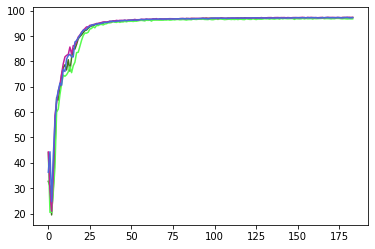

ROUND 183
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.375164
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.155771
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.054997

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.340404
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.066740
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.740374

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.528295
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.037644
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss:

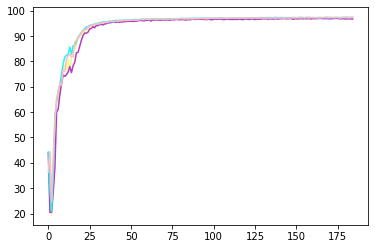

ROUND 184
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.534236
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.402456
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.174603

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.356878
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.118404
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.116538

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.341966
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.075044
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss:

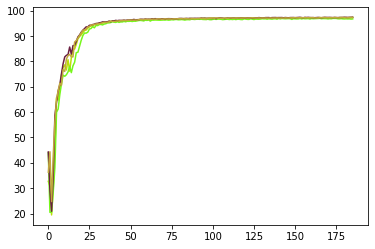

ROUND 185
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.457275
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.049723
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.482093

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.516878
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.104576
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.355618

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.345685
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.075978
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss:

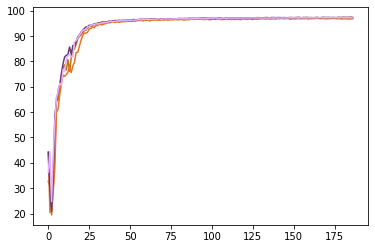

ROUND 186
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.266947
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.102725
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.192315

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.376662
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.116205
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.054622

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.250253
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.116965
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss:

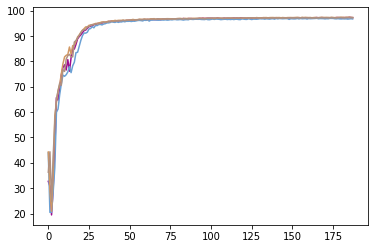

ROUND 187
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.305423
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.073837
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.035161

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.382921
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.014388
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.066769

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.392337
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.061067
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss:

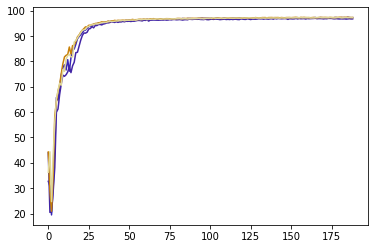

ROUND 188
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.509274
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.004305
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.047624

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.341215
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.496181
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.449447

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.441865
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.137593
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss:

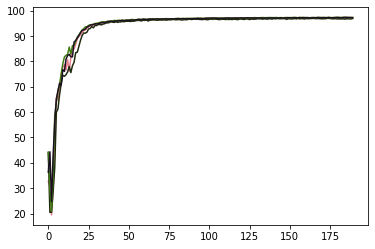

ROUND 189
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.498794
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.075882
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.234686

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.488776
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.067301
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.216846

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.325510
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.039864
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss:

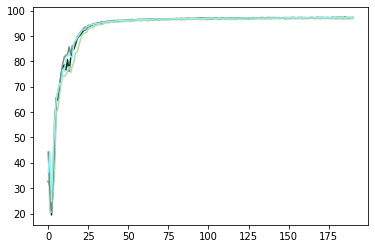

ROUND 190
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.532291
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.049729
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.329929

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.456816
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.062336
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.453316

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.294533
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.178596
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss:

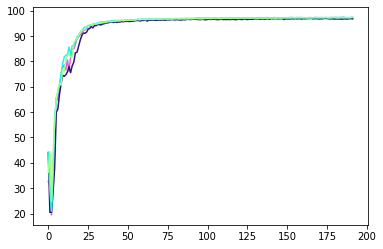

ROUND 191
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.388723
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.078769
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.109494

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.503377
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.119563
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.746494

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.484848
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.029417
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss:

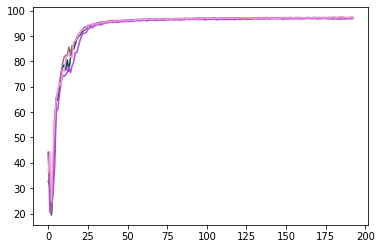

ROUND 192
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.346498
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.234325
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.063407

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.267323
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.143103
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.061923

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.418590
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.286563
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss:

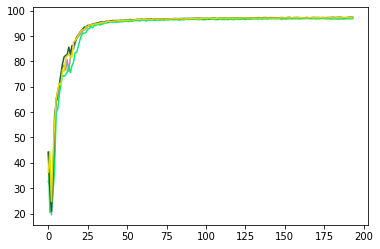

ROUND 193
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.395675
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.045112
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.026408

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.360172
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.253967
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.328371

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.256578
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.067137
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss:

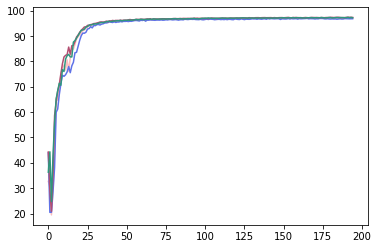

ROUND 194
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.293448
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.118478
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.031182

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.523942
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.045999
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.086569

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.355572
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.049364
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss:

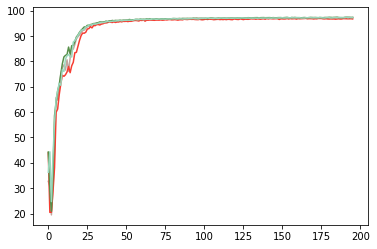

ROUND 195
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.358604
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.109568
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.231426

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.334528
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.019362
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.019854

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.421606
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.089867
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss:

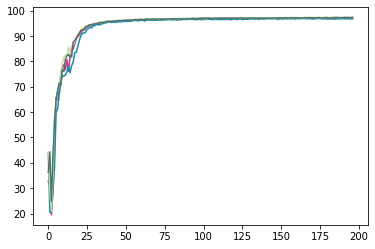

ROUND 196
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.275901
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.056466
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.069281

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.502803
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.013173
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.364313

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.423425
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.066406
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss:

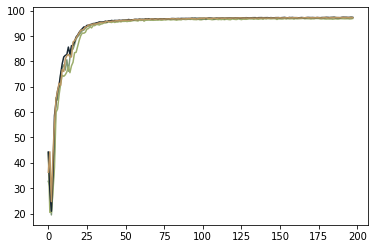

ROUND 197
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.505152
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.029103
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.172910

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.351268
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.253268
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.480465

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.364536
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.131545
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss:

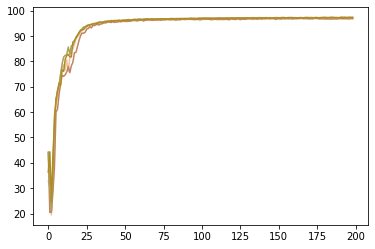

ROUND 198
0.11742000000001561
Power Allocated= 4.000428447372924
CSI= 0.22143449236461832
SNR= 26.247026073222663
Client: client11
Model client11 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.411565
Model client11 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.024450
Model client11 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.000630

Power Allocated= 0
CSI= 0.11402334016908133
SNR= 24.557234422195897
Client: client14
Poor Channel, client not taken for averaging in this round

Power Allocated= 0.859705756585833
CSI= 0.13060404034083206
SNR= 26.253630303384178
Client: client15
Model client15 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.307297
Model client15 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.108783
Model client15 Train Epoch: 3 [0/1216 (0%)]	Loss: 0.206971

Power Allocated= 5.446641751710597
CSI= 0.32575465442925355
SNR= 29.70732968304741
Client: client16
Model client16 Train Epoch: 1 [0/1216 (0%)]	Loss: 0.363497
Model client16 Train Epoch: 2 [0/1216 (0%)]	Loss: 0.051427
Model client16 Train Epoch: 3 [0/1216 (0%)]	Loss:

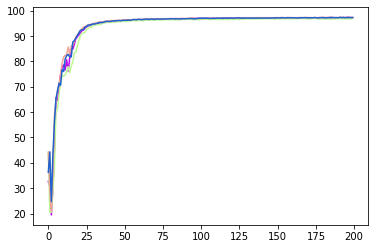

ROUND 199


In [14]:
for client in clients: #give the model and optimizer to every client
    torch.manual_seed(args.torch_seed)
    client['model'] = Net().to(device)
    #client['model'] = torch.quantization.quantize_dynamic(
    #client['model'],  # the original model
    #{torch.nn.Linear},  # a set of layers to dynamically quantize
    #dtype=torch.fp)  # the target dtype for quantized weights
    client['optim'] = optim.SGD(client['model'].parameters(), lr=args.lr)

final_acc=[]
final_loss=[]
    
for fed_round in range(args.rounds):
    overall=Net()
    if(fed_round==0): #fed_round==0
        arranged_clusters,head_snr_list=cluster_former(args.numclusters,args.clients)
        temp=deepcopy(arranged_clusters)
        temp2=deepcopy(head_snr_list)
    else:
        #print(temp)
        arranged_clusters=deepcopy(temp)
        head_snr_list=deepcopy(temp2)
#     print(arranged_clusters)
    
    no=1
    heads_list=[]
    weights=[]
    weight_head_list=[]
    head_acc=[]
    head_loss=[]
    for cluster in arranged_clusters:
        
        head=cluster['Cluster Head']
        members=cluster['Members']
        snrs=cluster['SNR']
        csis=cluster['CSI']
        weights.append(sum(snrs))
        weight_head_list.append([head,sum(snrs)])
        new_members=[]
        
        for ij in members:
        #print(ij)
            cl_no=int(ij[6:])
            new_members.append(clients[cl_no-1])
#         print(head)
        head=clients[int(head[6:])-1]
        cluster['Members']=new_members
#         print(head)

        smallmu1=0
        gsmall1=3.402823466E+38 
        
        #water filling algorithm
        mu=1e-15
        while(mu<=1):
            g1=0
            pn1=0
            for jj in csis:
                pn=max(1/mu-1/jj,0)
                g1+=math.log(1+pn*jj) #capacity of a channel (shannon's law)
                pn1+=pn
            g=g1-mu*(pn1-P*30)
            if(g<gsmall1):
                smallmu1=mu
                gsmall1=g
            mu+=0.00002
        
        print(smallmu1)
        good_mem=[]
#         print(len(snrs))
#         print(len(csis))
#         print(len(new_members))
        index=0
        for client in new_members:
            goodchannel=ClientUpdate(args, device, client,key_np,key,snrs[index],csis[index],smallmu1,head)
            index+=1
            if(goodchannel):
                good_mem.append(client)
        
        head['model']=averageModels(head['model'], good_mem)
        arr=test(args,head['model'], device, global_test_loader, 'Cluster'+str(no),fed_round)
        ac=arr[0]#test(args,head['model'], device, global_test_loader, 'Cluster'+str(no),fed_round)[0]
        no+=1
        heads_list.append(head)
        head_acc.append(ac)
        head_loss.append(arr[1])#test(args,head['model'], device, global_test_loader, 'Cluster'+str(no),fed_round)[1])
    
    final_acc.append(head_acc)
    final_loss.append(head_loss)
    fig,ax=plt.subplots()
    clor = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)]) for i in range(args.numclusters)]
    #ax.plot([i for i in range(fed_round)],head_acc[0])
    for jj in range(0,args.numclusters):
        
        ax.plot([i for i in range(len(final_acc))],[final_acc[j][jj] for j in range(len(final_acc))], color = clor[jj])
        
    #ax.plot([i for i in range(len(final_acc))],[final_acc[j][0] for j in range(len(final_acc))], color ="red")
    #ax.plot([i for i in range(len(final_acc))],[final_acc[j][1] for j in range(len(final_acc))],color ="blue")
    #ax.plot([i for i in range(len(final_acc))],[final_acc[j][2] for j in range(len(final_acc))],color ="green")
    #ax.plot([i for i in range(len(final_acc))],[final_acc[j][3] for j in range(len(final_acc))],color ="black")
    #ax.plot([i for i in range(len(final_acc))],head_acc[1], fed_round, color ="blue")
    #ax.plot([i for i in range(len(final_acc))],head_acc[2], fed_round, color ="green")
    #ax.plot([i for i in range(len(final_acc))],head_acc[3], fed_round, color ="black")
    
    
    plt.show()
    weightsum=sum(weights)
    
    weights[:] = [x / weightsum for x in weights]
    for aah in range(len(weight_head_list)):
        weight_head_list[aah][1]=weights[aah]
    final_heads,nets=decentralized(heads_list,head_snr_list,weight_head_list)
    
    for head in range(len(final_heads)):
        for cluster in arranged_clusters:
            head1=cluster['Cluster Head']
            if(head1==final_heads[head]['hook'].id):
                for mem in cluster['Members']:
                    mem['model'].load_state_dict(nets[head].state_dict())
    print("ROUND",fed_round)

In [15]:
print(final_acc)

[[32.71, 43.96, 44.27, 36.31], [30.77, 20.47, 29.06, 44.35], [19.47, 20.52, 20.92, 24.71], [30.16, 28.53, 34.99, 42.91], [44.95, 38.13, 58.61, 56.01], [65.71, 59.93, 63.87, 65.14], [64.73, 61.21, 68.34, 68.41], [69.04, 66.88, 70.77, 71.38], [74.64, 71.07, 75.07, 70.58], [77.56, 74.55, 79.05, 76.73], [78.62, 74.1, 81.73, 76.02], [76.58, 74.72, 82.36, 80.89], [80.64, 75.82, 82.7, 82.23], [76.1, 77.97, 85.64, 82.75], [81.39, 75.54, 82.84, 81.77], [85.0, 78.25, 86.18, 81.75], [84.83, 79.63, 86.28, 87.6], [86.68, 83.41, 87.8, 88.18], [88.87, 83.56, 89.59, 89.2], [89.75, 85.97, 90.38, 90.28], [90.44, 88.27, 91.45, 91.28], [91.27, 90.13, 92.26, 92.23], [92.13, 91.16, 92.88, 92.4], [92.34, 91.1, 93.57, 92.68], [93.06, 91.48, 93.56, 93.56], [93.65, 92.74, 94.19, 93.71], [93.94, 92.94, 94.23, 94.3], [93.9, 93.68, 94.5, 94.36], [94.54, 93.2, 94.62, 94.44], [94.53, 94.13, 94.91, 94.74], [94.86, 94.08, 94.95, 94.77], [94.94, 94.49, 95.12, 94.79], [95.13, 94.54, 95.29, 95.04], [95.07, 94.34, 95.54, 